# Introduction

**Objective:**  
Engineer a product recommendation system for an e-commerce website that leverages collaborative filtering and customer segmentation. 
    
**Methodology:**  
Users are separated into repeat customers and first time customers and the recommendation system works as follows. 
* Repeat Customers
    * Collaborative filtering recommendation
    * Customer segmentation recomendation 
    * Popular in your area
    
* New Customers
    * Hot products
    * Popular in your area
    * Top Stores

**Data:** 
https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv

**Inspiration:** 
* https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
* https://www.kaggle.com/robottums/hybrid-recommender-systems-with-surprise

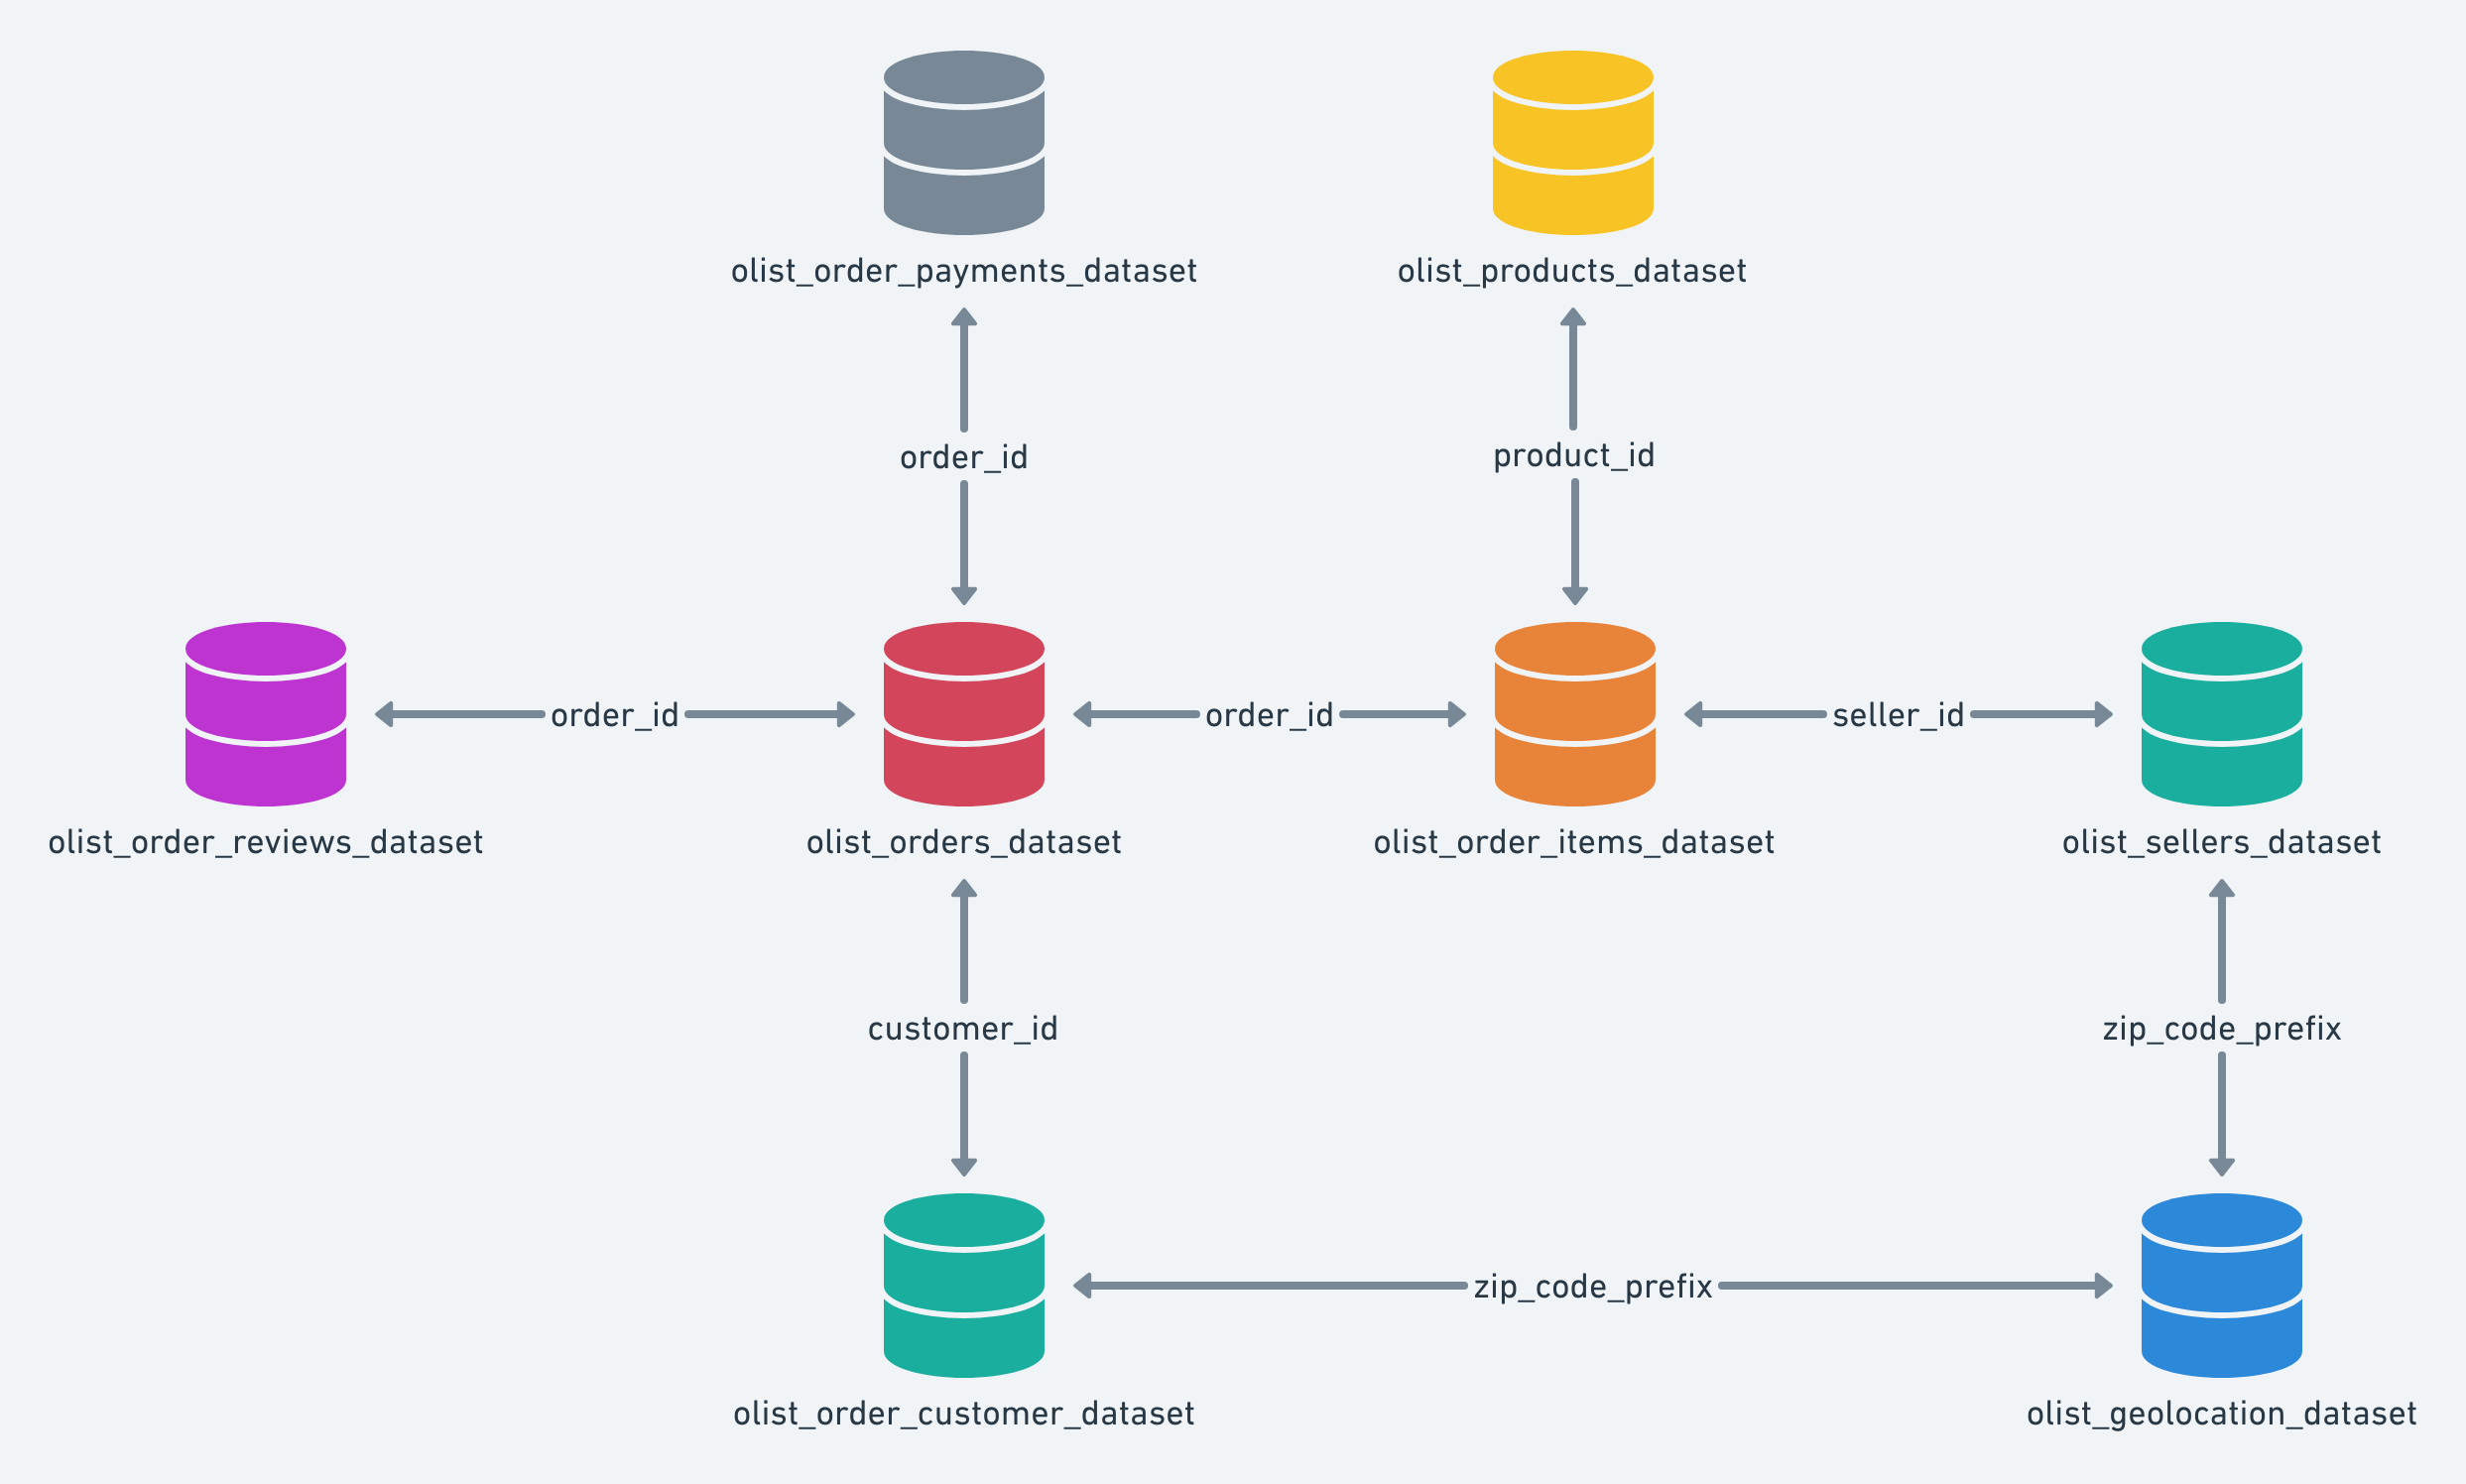

In [2]:
# Display database schema in AWS PostgreSQL
from IPython.display import Image
Image("HRhd2Y0.png")

In [110]:
import pandas as pd
import numpy as np
from collections import defaultdict

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from scipy.sparse import csr_matrix
from scipy import stats

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import math
from datetime import datetime

from pandas.plotting import autocorrelation_plot

# Connecting to AWS Postgres

In [18]:
params = {
    'host': '18.225.37.13',
    'user': 'ubuntu',
    'port': 5432
}

# This is a different way of creating tables
# It is convinient if there are many columns

connection_string = f'postgres://ubuntu:{params["host"]}@{params["host"]}:{params["port"]}/olist'
engine = create_engine(connection_string)

In [19]:
connection = pg.connect(**params)

# Loading and Cleaning Data

## Querying Data With SQL

In [20]:
def query_aws(query, engine):
    return pd.read_sql(query,engine)

In [22]:
query = """
        SELECT 
            customers.customer_unique_id, 
            customers.customer_zip_code_prefix, 
            customers.customer_city,
            customers.customer_state,
            order_item.order_id,
            order_item.product_id,
            order_item.seller_id,
            order_item.price,
            orders.order_purchase_timestamp,
            orders.order_delivered_customer_date,
            orders.order_estimated_delivery_date,
            payments.payment_type,
            payments.payment_installments,
            payments.payment_value,
            reviews.review_score,
            products.product_weight_g,
            product_category.product_category_name_english,
            sellers.seller_zip_code_prefix,
            sellers.seller_state,
            sellers.seller_state
        FROM customers
            JOIN orders
                on orders.customer_id=customers.customer_id
            JOIN reviews
                on reviews.order_id=orders.order_id
            JOIN order_item
                on order_item.order_id=orders.order_id
            JOIN payments
                on payments.order_id=orders.order_id
            JOIN products
                on products.product_id=order_item.product_id
            JOIN product_category
                on product_category.product_category_name=products.product_category_name
            JOIN sellers
                on sellers.seller_id=order_item.seller_id
            
        """

olist_data = query_aws(query, engine)

In [23]:
# Save dataset to csv file
olist_data.to_csv('data/01_olist_aws_pulled.csv')

In [363]:
olist_data = pd.read_csv('data/01_olist_aws_pulled.csv')

## Viewing and Cleaning

In [364]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 21 columns):
Unnamed: 0                       116581 non-null int64
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null object
order_delivered_customer_date    114066 non-null object
order_estimated_delivery_date    116581 non-null object
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score                     116581 non-null i

In [365]:
olist_data = olist_data.drop(columns=['Unnamed: 0', 'seller_state.1'])

In [366]:
# some purchases are payed with by vouchers which causes them to split into many lines of
# smaller payments. To normalize with the rest of the data, combining these values into 
# one total payment value

def create_total_payment_value(data):
    data['total_payment'] = data['payment_value'].groupby(data['order_id']).transform('sum')
    data= data.drop('payment_value', axis=1)
    return data

In [367]:
olist_data = create_total_payment_value(olist_data)

In [368]:
def duplicates(data):
    """Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values."""
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [369]:
olist_data = duplicates(olist_data)

There are 12969 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 103612 rows


In [408]:
# Convert order timestamp to datetime 
def convert_to_datetime(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp, 
                                                     format="%Y/%m/%d %H:%M:%S")
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    return data

olist_data = convert_to_datetime(olist_data)

In [371]:
# Adding 99% to 7 digit summary to understand how drastic the max_price outlier is
olist_data.describe([.75,.99])

,customer_zip_code_prefix,price,payment_installments,review_score,product_weight_g,seller_zip_code_prefix,total_payment
count,103612.000000,103612.000000,103612.000000,103612.000000,103611.000000,103612.000000,103612.000000
mean,35125.539918,124.490286,2.937150,4.061489,2096.389785,24627.129126,231.038923
std,29771.870475,188.972184,2.743117,1.364238,3750.600705,27678.848789,692.432702
min,1003.000000,0.850000,0.000000,1.000000,0.000000,1001.000000,9.590000
50%,24435.000000,78.000000,2.000000,5.000000,700.000000,13720.000000,114.760000
75%,58741.250000,139.000000,4.000000,5.000000,1800.000000,29156.000000,212.092500
99%,97541.000000,899.000000,10.000000,5.000000,18250.000000,93542.000000,1957.020000
max,99980.000000,6735.000000,24.000000,5.000000,40425.000000,99730.000000,109312.640000


In [372]:
# For now, not removing outliers but note that price and payment values both contain significan outliers

In [410]:
olist_data.to_csv('data/cleaned_olist_data.csv', index=False)

In [1598]:
olist_data=pd.read_csv('data/cleaned_olist_data.csv')

In [144]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 19 columns):
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null object
order_delivered_customer_date    101386 non-null object
order_estimated_delivery_date    103612 non-null object
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null float64
product_category_name_english    103612 non-null o

# EDA

In [1605]:
olist_blue  = '#0C29D1'
olist_green = '#0CC78B'

In [31]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 21 columns):
Unnamed: 0                       116581 non-null int64
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null datetime64[ns]
order_delivered_customer_date    114066 non-null datetime64[ns]
order_estimated_delivery_date    116581 non-null datetime64[ns]
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score              

## Consumers

In [11]:
olist_data.shape

(116581, 18)

In [9]:
# number of unique customers
olist_data.customer_unique_id.nunique()

94087

In [36]:
# Number of repeat customers
olist_data.shape[0] - olist_data.customer_unique_id.nunique()

22494

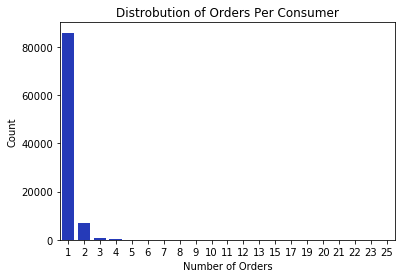

In [412]:
# Distrobution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distrobution of Orders Per Consumer');

In [169]:
# Number of repeat consumers vs single time consumers

def repeat_customers(data):
    repeat_customers = data.customer_unique_id.value_counts()
    return repeat_customers[repeat_customers > 1].count()

repeat_customers(olist_data)

8272

In [255]:
# Customer locations throughout Brazil

def customer_locations(data):
    return pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))

customer_locations = customer_locations(olist_data).reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})

print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")

top_ten_cities = customer_locations.city[:10]
customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

There are 4095 unique customer cities.

The majority of customers, 35.22 percent, live in the top ten cities.



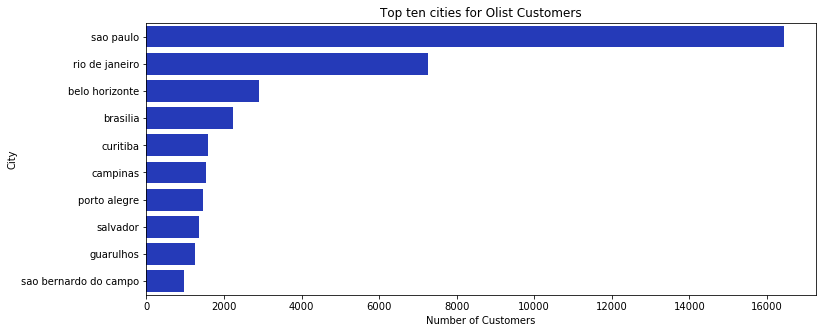

In [413]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## Orders

In [195]:
# Number of orders per day

def order_per_day(data):
    return data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])

order_per_day = order_per_day(olist_data)

print(f"Avg. number of orders per day: {np.mean(order_per_day)[0]}")

Avg. number of orders per day: 170.8780487804878


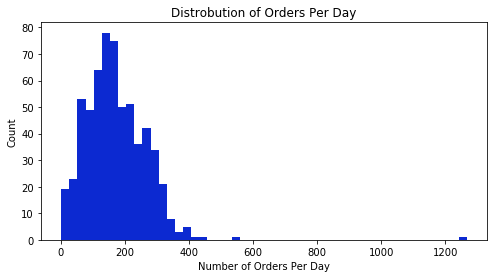

In [414]:
# Distrobution of orders per day
plt.figure(figsize=(8,4))
plt.hist(order_per_day['count'], bins=50, color=olist_blue)
plt.xlabel('Number of Orders Per Day')
plt.ylabel('Count')
plt.title('Distrobution of Orders Per Day');

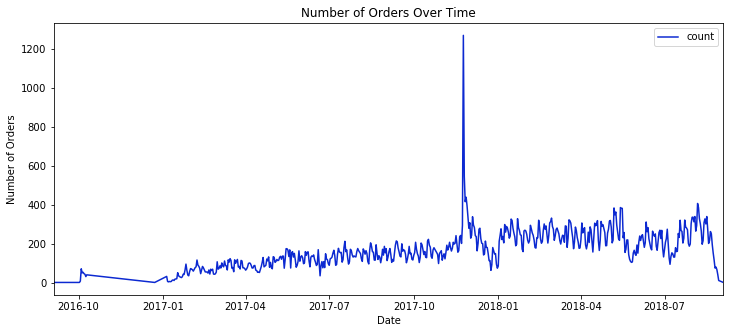

In [415]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
order_per_day.plot(ax=ax, use_index=True, color=olist_blue)
ax.set(xlabel='Date', ylabel='Number of Orders', title='Number of Orders Over Time');

There is a spike in orders around Christmas of 2017 but otherwise we see a pattern of general inflation of orders 

Avg. purchase price: 159.2856598632461


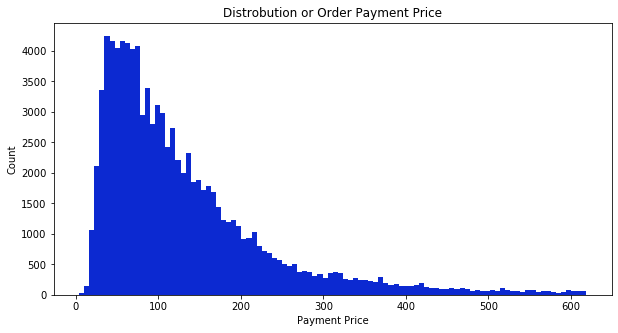

In [416]:
# Each line item represents a single item in an order. Group by order_id to find total purchase price for all orders
def purchase_payment_val(data):
    return data.groupby('order_id').payment_value.max()

purchase_payments = purchase_payment_val(olist_data)

print(f"Avg. purchase price: {purchase_payments.mean()}")


# view purchase price removing outliers in the top 3%
q_97 = purchase_payments.quantile(.97)
payments_97 = purchase_payments[purchase_payments < q_97]

# plot distrobution
plt.figure(figsize=(10,5))
plt.hist(payments_97, bins=100, color=olist_blue)
plt.xlabel('Payment Price')
plt.ylabel('Count')
plt.title('Distrobution or Order Payment Price');

In [289]:
# Number of items per order
def items_per_order(data):
    return data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')

avg_items_per_order = items_per_order(olist_data).mean()

print(f"Avg. number of items per order: {avg_items_per_order[0]}")

Avg. number of items per order: 1.0805614107243844


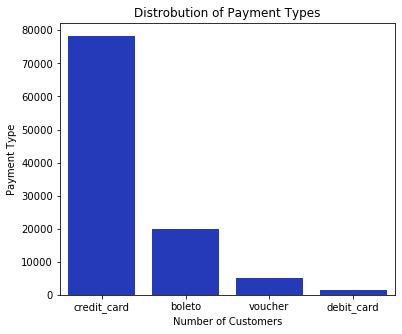

In [417]:
# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

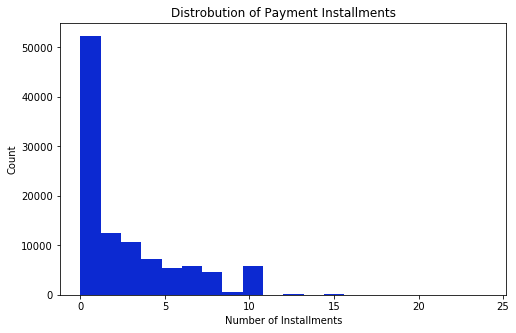

In [418]:
# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distrobution of Payment Installments');

## Sellers

In [ ]:
# Sales per seller

Avg. number of sales per seller: 34.16155621496868

The top 10 sellers account for 14.24 percent of the total sales

The top seller has 2034 sales


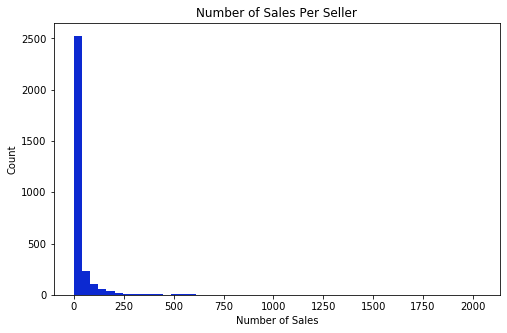

In [1610]:
def sales_per_seller(data):
    return data.groupby('seller_id')['order_id'].count()

sales_per_seller = sales_per_seller(olist_data)

print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")

top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

print(f"The top seller has {top_ten_sellers[0]} sales")

# view purchase price removing outliers in the top 3%
# s_q_97 = sales_per_seller.quantile(.97)
sellers_q_97 = sales_per_seller#[sales_per_seller < s_q_97]


plt.figure(figsize=(8,5))
plt.hist(sellers_q_97, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

## Products

Number of unique products: 32328

Average price per product: 120.75136917679554

Average sales per product: 3.6061927740658253

Top ten selling products:
aca2eb7d00ea1a7b8ebd4e68314663af    536
99a4788cb24856965c36a24e339b6058    528
422879e10f46682990de24d770e7f83d    508
389d119b48cf3043d311335e499d9c6b    406
368c6c730842d78016ad823897a372db    398
53759a2ecddad2bb87a079a1f1519f73    391
d1c427060a0f73f6b889a5c7c61f2ac4    357
53b36df67ebb7c41585e8d54d6772e08    327
154e7e31ebfa092203795c972e5804a6    295
3dd2a17168ec895c781a9191c1e95ad7    278
Name: product_id, dtype: int64

The top ten selling products account for 3.45 percent of the product sold.



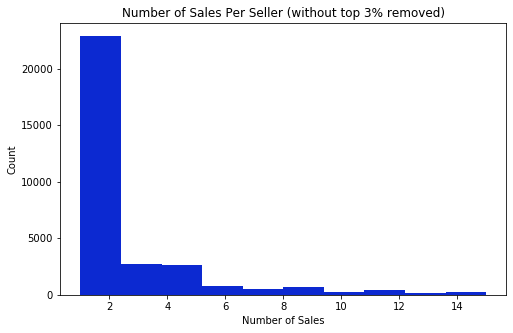

In [58]:
# Average product cost
print(f"Number of unique products: {olist_data.product_id.nunique()}\n")
print(f"Average price per product: {olist_data.price.mean()}\n")

# Most sold products
def num_products_sold(data):
    return data.product_id.value_counts()

number_prod_sold = num_products_sold(olist_data)

print(f"Average sales per product: {number_prod_sold.mean()}\n")

top_ten_products = number_prod_sold[:10]
print(f"Top ten selling products:\n{top_ten_products}\n")
print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")


p_q_97 = number_prod_sold.quantile(.97)
products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

plt.figure(figsize=(8,5))
plt.hist(products_q_97, bins=10, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller (without top 3% removed)');

The top reviewed products are
                              product_id  mean  count
29803  ebf9bc6cd600eadd681384e3116fda85   5.0     44
627    0554911df28fda9fd668ce5ba5949695   5.0     38
11942  5ddab10d5e0a23acb99acf56b62b3276   5.0     21
16932  85b99d83c60cab5b4d8f927ad35212a1   5.0     17
23419  b9aad83bfbc546d2e4e7a7fa8e15bc9c   5.0     16
995    07f01b6fcacc1b187a71e5074199db2d   5.0     15
7133   37eb69aca8718e843d897aa7b82f462d   5.0     15
20022  9e5f752e9e19cd6887063f004ee0da55   5.0     15
22907  b5ebab9fa4b5f2771ec47a5d6139f3ff   5.0     15
457    03e1c946c0ddfc58724ff262aef08dff   5.0     14


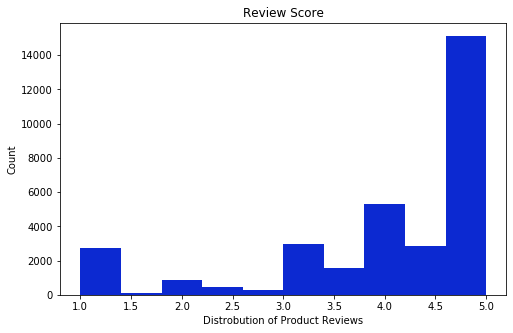

In [51]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    return data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()

reviewed_products = product_reviews(olist_data)
top_ten_reviewed_products = reviewed_products.sort_values(by=['mean','count'],ascending=False)[:10]

print(f"The top reviewed products are\n {top_ten_reviewed_products}")


plt.figure(figsize=(8,5))
plt.hist(reviewed_products['mean'], bins=10, color=olist_blue)
plt.xlabel('Distrobution of Product Reviews')
plt.ylabel('Count')
plt.title('Review Score');

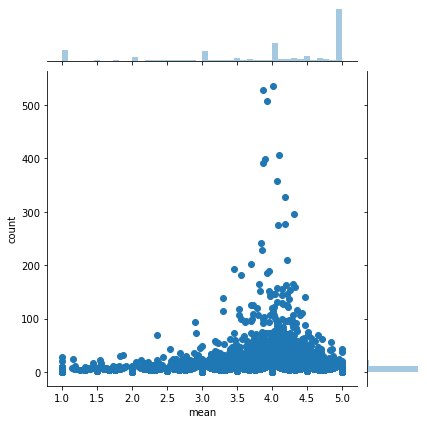

In [53]:
# observe the relationship between rating and number of reviews
sns.jointplot(x=reviewed_products['mean'], y=reviewed_products['count'], data=reviewed_products);

There are 71 categories


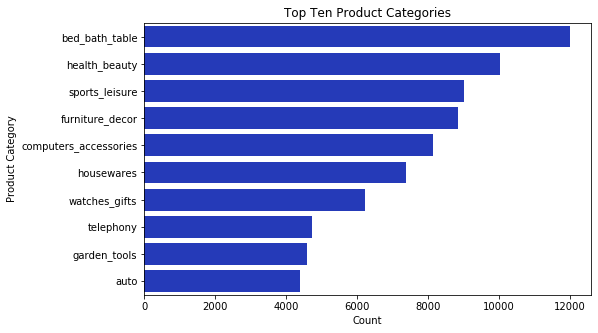

In [18]:
# Product cateogires

print(f"There are {olist_data.product_category_name_english.nunique()} categories")

top_ten_categories = olist_data.product_category_name_english.value_counts().sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
ax = sns.barplot(top_ten_categories.values, top_ten_categories.index, color=olist_blue)
ax.set(xlabel='Count', ylabel='Product Category', title='Top Ten Product Categories');

# Separating Repeat and First Time Users

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.  

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by how many predictions are right using the recommender vs. how many are right when just recommending the most popular item.  

**For New Users:** Recommendation based on 
* Customer Segmentation, then pick the top product in that customer base
* People in your area, then pick the top products in that customer base   

Results are measured by comparing predictions to the overall most popular item

In [346]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
    return repeaters, first_timers

In [348]:
repeater_data, first_timer_data = repeat_and_first_time(olist_data)

In [413]:
# Save datasets for easier accessing
repeater_data.to_csv('data/repeater_data.csv')
first_timer_data.to_csv('data/first_timer_data.csv')

In [ ]:
# View the size of the new datasets
print("Shape of repeater dataset:", repeater_data.shape)

print("Shape of first timer dataset:", first_timer_data.shape)

In [1577]:
repeater_data = pd.read_csv('data/repeater_data.csv')
first_timer_data = pd.read_csv('data/first_timer_data.csv')

In [1578]:
repeater_data['repeater'] = 1
first_timer_data['repeater'] = 0

In [1579]:
full_df = pd.concat((repeater_data, first_timer_data), axis=0).drop('Unnamed: 0', axis=1).reset_index()

In [1580]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 21 columns):
index                            103612 non-null int64
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null object
order_delivered_customer_date    101386 non-null object
order_estimated_delivery_date    103612 non-null object
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null flo

In [352]:
r = repeater_data.shape[0]
f = first_timer_data.shape[0]

r/(r+f)

0.16709454503339383

In [406]:
first_timer_data.customer_unique_id.value_counts().sort_values()

ed5c1ba63258ae10563aacd2ca022ab2    1
7124791ca25bad043d51953cd3265213    1
80768413a59684f1e4c68a4e85feac9d    1
86f5ea139f5fb8d91a5a340d85b128e4    1
1bf6765c243d6039297f4f49948e53ad    1
                                   ..
f525ea95844284b57cfa8d6d31db613b    1
e42c4dd98307152b732690ea8bc5f61d    1
0b052dec06c1d5bdf49eb19ad47cb630    1
1534c2f0660461d99aeb09455e18f23c    1
46028f2d6b2f3c010fa407a0d19dadc9    1
Name: customer_unique_id, Length: 86299, dtype: int64

# Repeat Customers

The full data set is filtered down to only repeat customers. Train data is all purchases except for the most recent. Test set includes the last order from each customer. The goal is to predict the most recent purchase (conceptually it is the next order after the train set).

## Preparing Dataframes

### Method 1: Purchase Count

In [642]:
def create_puchase_count_df(data):
    purchase_count = pd.melt(data.set_index('customer_unique_id')['product_id'].apply(pd.Series).reset_index(), 
                 id_vars=['customer_unique_id'],
                 value_name='product_id')
    purchase_count = purchase_count.dropna().drop(['variable'], axis=1)
    purchase_count = purchase_count.groupby(['customer_unique_id', 'product_id']).agg({'product_id': 'count'})
    purchase_count = purchase_count.rename(columns={'product_id': 'estimator'}).reset_index()
    purchase_count = purchase_count.rename(columns={'product_id': 'productId'})
    
    return purchase_count

In [643]:
purchase_count_df = create_puchase_count_df(repeater_data)

In [644]:
purchase_count_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,2
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,1
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,1


### Method 2: Dummy Variables

In [657]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['estimator2'] = 1
    data_dummy = data_dummy.drop('estimator', axis=1)
    data_dummy = data_dummy.rename({'estimator2':'estimator'}, axis=1)
    return data_dummy

In [658]:
dummy_df = create_data_dummy(purchase_count_df)

In [659]:
dummy_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,1
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,1
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,1


### Method 3: Normalize Purchase Frequency

In [663]:
def normalize_purchase_count(data):
    count_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())
    count_matrix_norm = count_matrix_norm.reset_index()
    count_matrix_norm.index.names = ['scaled_purchase_freq']
    
    normalized_count_matrix = pd.melt(count_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_count_matrix

In [664]:
normalized_purchase_count_df = normalize_purchase_count(purchase_count_df)

In [665]:
normalized_purchase_count_df.head()

,customer_unique_id,productId,estimator
17446,3f36fa15a16c4850992aa0f33561906e,00210e41887c2a8ef9f791ebc780cc36,0.0
20383,9e37889f07854b8ae7d49bcbb49ffaf2,00210e41887c2a8ef9f791ebc780cc36,1.0
162091,d02cbb85434c84acabb8e81bbf064d3e,00baba5b58e274d0332a0c8a0a66f877,1.0
162250,d567f29ec5fa447c99e949f337f3a35c,00baba5b58e274d0332a0c8a0a66f877,0.0
211988,397b44d5bb99eabf54ea9c2b41ebb905,00faa46f36261af8bbf3a4d37fa4841b,1.0


### Method 4: User Ratings Matrix

In [666]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
    
#     user_prod_reviewscore_data.avg_rating = user_prod_reviewscore_data.avg_rating.apply(lambda x: 1)
    
    return user_prod_reviewscore_data

In [667]:
user_ratings_df = create_user_ratings_df(repeater_data)

In [668]:
user_ratings_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1.0
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1.0
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,4.5
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,2.0
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,2.0


### Method 5: Normalized User Ratings Matrix

In [669]:
def normalize_purchase_count(data):
    ratings_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    ratings_matrix_norm = (ratings_matrix-ratings_matrix.min())/(ratings_matrix.max()-ratings_matrix.min())
    ratings_matrix_norm = ratings_matrix_norm.reset_index()
    ratings_matrix_norm.index.names = ['estimator']
    
    normalized_ratings_matrix = pd.melt(ratings_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_ratings_matrix

In [670]:
normalized_user_ratings_df = normalize_purchase_count(user_ratings_df)

In [673]:
normalized_user_ratings_df.head()

,customer_unique_id,productId,estimator
17446,3f36fa15a16c4850992aa0f33561906e,00210e41887c2a8ef9f791ebc780cc36,1.0
20383,9e37889f07854b8ae7d49bcbb49ffaf2,00210e41887c2a8ef9f791ebc780cc36,0.0
69358,e76c6b66892fdab38f6bafcd081e034e,003dbcabcf8e3231de657c7d9f9a5eba,1.0
69908,f99f4e4db672e22718b5ad0e910ede8a,003dbcabcf8e3231de657c7d9f9a5eba,0.0
83164,ae864af1d62fc952073ddcd1ab59a233,005030ef108f58b46b78116f754d8d38,1.0


## Determinging Model Framework

In [829]:
def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [], [], [], [], []

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))
        
        #slope_one
        slope = SlopeOne() 
        slope.fit(trainset)
        slope_pred = slope.test(testset)
        slope_rmse.append(accuracy.rmse(slope_pred,verbose=False))
    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse),
                  np.mean(slope_rmse)]
    
    model_names = ['baseline', 'svd','knn','coclustering','slopeone']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)
    
    return compare_df

In [834]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_count', 
                                       'dummy',
                                       'norm_purchase_count', 
                                       'user_ratings', 
                                       'norm_user_ratings']])
    
    return comp_matrix
    

In [835]:
all_methods = [purchase_count_df, dummy_df, normalized_purchase_count_df, user_ratings_df, normalized_user_ratings_df]

In [836]:
comparison_matrix = model_comparison(all_methods)

Initial dataframe created.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.


In [845]:
# create a column to indicate percentage better performance than baseline so that 
# centered and non-centered datasets can be compared
comparison_matrix['best_score'] = comparison_matrix.min(axis=1)
comparison_matrix['method_comparison'] = 100*(1-(comparison_matrix.best_score/comparison_matrix.baseline)) 
comparison_matrix

,baseline,svd,knn,coclustering,slopeone,best_score,method_comparison
purchase_count,0.536567,0.410806,0.424937,0.432835,0.415376,0.410806,23.438101
dummy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
norm_purchase_count,0.579549,0.477842,0.462029,0.459033,0.444857,0.444857,23.240896
user_ratings,1.971325,1.362263,1.478314,1.434971,1.339884,1.339884,32.031295
norm_user_ratings,0.563375,0.460869,0.427093,0.456429,0.405887,0.405887,27.954353


Best performer was the user ratings matrix. Although slopeone performed best, svd will be explored using grid search to tune hyperparameters.

## Tuning Winning Model (SVD)

For the final model, will continue to leverage the user rating matrix as it requires minimal computational expense and maximum variance.

### Gridsearch

In [850]:
def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [853]:
# standard svd gridsearch
data = surprise_df(user_ratings_df)

svd_param_grid = {'n_factors': [25, 50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid)

Best score: 1.276697600716385
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [854]:
# svdpp gridsearch

svdpp_param_grid = {'n_factors': [10, 20, 50],'n_epochs': [20,30,50], 'lr_all': [0.002,0.007,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svdpp_params, svdpp_score = gridsearch(data, SVDpp, svdpp_param_grid)

Best score: 1.2741892218744408
Best params: {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


### Comparing all SVD models

In [882]:
def svd_model(data, model_list, model_names):
    all_scores = []
    
    for model in model_list:
        model_rmse = []
        model_mae = []
        
        for trainset, testset in kf.split(data): #iterate through the folds.

            mod = model
            mod.fit(trainset)
            pred = mod.test(testset)
            model_rmse.append(accuracy.rmse(pred,verbose=False))
            model_mae.append(accuracy.mae(pred,verbose=False))
            
        all_scores.append([np.mean(model_rmse), np.mean(model_mae)])
    
    results = pd.DataFrame(all_scores, index=model_names, columns=['rmse','mae'])
    
    return results  

In [883]:
def svd_comparisons():
    # For comparison, baseline model
    random = NormalPredictor()

    # Standard SVD models
    tuned_svd = SVD(n_factors=svd_params['n_factors'], 
                    n_epochs=svd_params['n_epochs'],
                    lr_all=svd_params['lr_all'], 
                    reg_all=svd_params['reg_all'])

    standard_svd = SVD()

    # SVDpp moddels
    tuned_svdpp = SVDpp(n_factors=svdpp_params['n_factors'], 
                        n_epochs=svdpp_params['n_epochs'],
                        lr_all=svdpp_params['lr_all'], 
                        reg_all=svdpp_params['reg_all'])

    standard_svdpp = SVDpp()


    model_list = [random, tuned_svd, standard_svd, tuned_svdpp, standard_svdpp]
    model_names = ['random','tuned_svd','standard_svd','tuned_svdpp','standard_svdpp']

    return svd_model(data, model_list, model_names)

In [884]:
svd_comparison_df = svd_comparisons()
svd_comparison_df

,rmse,mae
random,1.977622,1.559012
tuned_svd,1.284523,1.073183
standard_svd,1.447653,1.244912
tuned_svdpp,1.280175,1.067921
standard_svdpp,1.413678,1.212317


In [887]:
svdpp_performance = 100*(1-(svd_comparison_df.loc['tuned_svdpp', 'rmse'] / svd_comparison_df.loc['random', 'rmse']))
print(f"Tuned SVDpp performed {svdpp_performance} better than baseline.")

Tuned SVDpp performed 35.266922083017924 better than baseline.


## Final Model

In [1650]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
        
    return user_prod_reviewscore_data

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df



In [1651]:
def final_model(data):
    user_product_df = create_user_ratings_df(data)
    user_ratings_matrix = surprise_df(user_product_df)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.2, random_state=19)
    
    params = {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} 
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(repeater_data)

In [1652]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

In [1653]:
best_predictions = recommendation_results.sort_values(by='err')[:10]
worst_predictions = recommendation_results.sort_values(by='err')[-10:]

In [110]:
# df.est = df.est.apply(lambda x: math.ceil(x) if x > 3.5 else x)
# df.est = df.est.apply(lambda x: math.floor(x) if x <= 3.5 else x)

In [1654]:
recommendation_results.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,5c5a99e5ef172fbf5fc8a68e6bb2e0ab,7138c5cd9a02964ede6383ffac29e5be,5.0,4.142763,{'was_impossible': False},1,0,0.857237
1,9bf8115570e9625107dd9705f6941f3a,8aa87bc5f3053b4df2b05a2d3059790b,5.0,4.138410,{'was_impossible': False},1,0,0.861590
2,1b7b7f9631cd453251d0b328c9b38a2a,a069fc741ff92fd8af8270a66f35fcbd,5.0,4.108417,{'was_impossible': False},1,0,0.891583
3,b0177912ddf632d8639faab15385a07a,c05aabbc0dbb2f3569cb54fe92fee96d,5.0,3.766724,{'was_impossible': False},0,0,1.233276
4,8dafb82f687e3b0dc9e97b4198b92128,ba141ee1157c8499edebf350c898084b,5.0,4.125566,{'was_impossible': False},1,0,0.874434


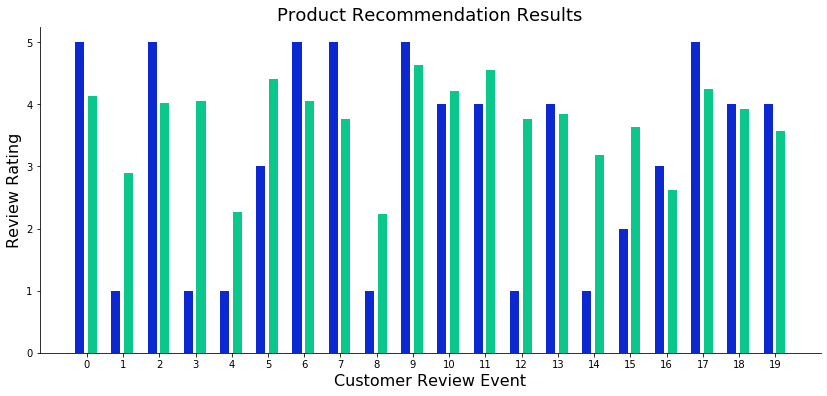

In [1702]:
fig, ax = plt.subplots(figsize=(14, 6))
ind = np.arange(0,20)
pad = 0.15
width = 0.35
x1 = range(0,40,2)
x2 = list(np.linspace(.7,38.7, 20))
label_loc = list(np.linspace(.4,38.4, 20))

ax.bar(x1, recommendation_results.rui[20:40], color=olist_blue, width=0.5,)
ax.bar(x2, recommendation_results.est[20:40], color=olist_green, width=0.5)

plt.title('Product Recommendation Results', fontsize=18)
plt.ylabel('Review Rating', fontsize=16)
plt.xlabel('Customer Review Event', fontsize=16, ha='center');
ax.set_xticks(label_loc)
ax.set_xticklabels(list(range(20)), fontsize=10)
sns.despine()

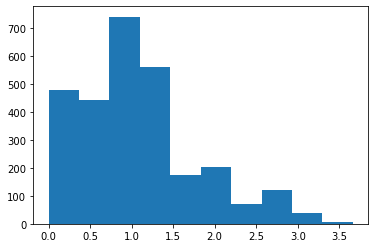

In [113]:
plt.hist(recommendation_results.err);

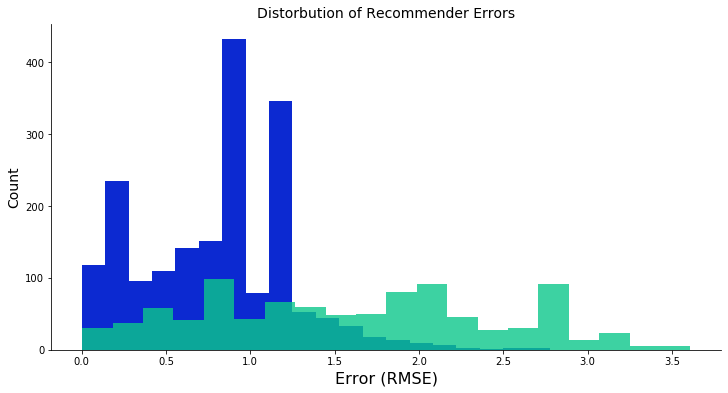

In [1699]:
real_over_three = recommendation_results[recommendation_results.rui > 3].err
real_three_under = recommendation_results[recommendation_results.rui <= 3].err
plt.figure(figsize=(12,6))
plt.hist(real_over_three, bins=20, color=olist_blue, label='Actual Rating >3')
plt.hist(real_three_under, bins=20, color=olist_green, alpha=.8, label='Actual Rating <=3')
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();

In [1677]:
real_over_three.mean()

0.8089491088225337

In [1678]:
real_three_under.mean()

1.5825449606949193

In [1679]:
recommendation_results.err.mean()

1.0672680614709833

In [1704]:
# Check accuracy of saying if a customer will like the product or not by checking accuracy for predicting > 3
recommendation_results['actual_over3'] = recommendation_results.rui.apply(lambda x: 1 if x>3 else 0)
recommendation_results['pred_over3'] = recommendation_results.est.apply(lambda x: 1 if x>3 else 0)

In [1710]:
# if actual - predicted = 0, count as correct. If 1 or -1 responses were different, count as incorrect.
recommendation_results['over3_accuracy'] = recommendation_results.actual_over3 - recommendation_results.pred_over3
accuracy_over3 = recommendation_results.over3_accuracy.value_counts(normalize=True)*100
accuracy_over3

 0    74.947220
-1    24.067558
 1     0.985222
Name: over3_accuracy, dtype: float64

# First Time Users

## Popular In Your Area

## Hot Items

Most popular items of the last week

In [ ]:
# Likely to sell > average

### popular in your area

# Customer segmentation

### Feature Engineering and Selection

In [168]:
# def segmentation_feature_engineering(data):
#     data['avg_payment_price'] = data.groupby('customer_unique_id')['total_payment'].transform('mean')
#     print("Step 1 complete.")
    
#     data['avg_installments'] = data.groupby('customer_unique_id')['payment_installments'].transform('mean')
#     print("Step 2 complete.")
    
#     data['number_of_orders'] = data.groupby('customer_unique_id')['order_id'].transform('count')
#     print("Step 3 complete.")
    
#     data['total_products_ordered'] = data.groupby('customer_unique_id')['customer_unique_id'].transform('count')
#     print("Step 4 complete.")
    
#     data['avg_prod_per_order'] = data.total_products_ordered / repeater_data.number_of_orders
#     print("Step 5 complete.")
    
#     data['avg_review_score'] = data.groupby('customer_unique_id')['review_score'].transform('mean')
#     print("Step 6 complete.")
    
#     data['avg_prod_weight'] = data.groupby('customer_unique_id')['product_weight_g'].transform('mean')
#     print("Step 7 complete.")
    
#     data['most_common_category'] = data.groupby('customer_unique_id')['product_category_name_english'].transform(lambda x: x.mode().iat[0])    
#     print("Step 8 complete.")
    
#     data['common_payment_type'] = data.groupby('customer_unique_id')['payment_type'].transform(lambda x:x.x.mode().iat[0]) 
#     print("Step 9 complete.")
    
#     return data

# engineered_olist_df = segmentation_feature_engineering(olist_data)

Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 9 complete.


In [ ]:
# def feature_selection(data):
#     features = ['customer_unique_id','customer_state','common_payment_type','avg_payment_price',
#                 'avg_installments','number_of_orders','total_products_ordered','avg_prod_per_order',
#                 'avg_review_score','most_common_category','avg_prod_weight', 'product_id']
    
#     data_subset = data[features]
#     data_subset = data_subset.drop_duplicates(subset='customer_unique_id')
    
#     return data_subset

In [170]:
# engineered_olist_df = feature_selection(engineered_olist_df)

In [172]:
# engineered_olist_df.to_csv('data/engineered_olist_df.csv')

In [176]:
# engineered_olist_df = engineered_olist_df.dropna()

In [328]:
def customer_segmentation_feature_engineering(data):
    
    data['pay_per_installment'] = data['total_payment'] / data['payment_installments']
    print("Step 1 complete.")
    
    data['avg_pay_per_intallment'] = data.groupby('customer_unique_id')['pay_per_installment'].transform('mean')
    print("Step 2 complete.")
    
    data['number_of_orders'] = data.groupby('customer_unique_id')['order_id'].transform('count')
    print("Step 3 complete.")
    
    data['total_products_ordered'] = data.groupby('customer_unique_id')['customer_unique_id'].transform('count')
    print("Step 4 complete.")
    
    data['avg_review_score'] = data.groupby('customer_unique_id')['review_score'].transform('mean')
    print("Step 5 complete.")
    
    data['avg_prod_weight'] = data.groupby('customer_unique_id')['product_weight_g'].transform('mean')
    print("Step 6 complete.")
    
    data['total_payment_value'] = data.groupby('customer_unique_id')['total_payment'].transform('sum')
    print("Step 7 complete.")
    
    data['percent_of_orders'] = data.number_of_orders.apply(lambda x: x/np.sum(data.number_of_orders)*100)
    print("Step 8 complete.")
    
    data['most_common_cat'] = data.groupby('customer_unique_id')['product_category_name_english'].transform(lambda x: x.mode().iat[0])    
    print("Step 9 complete.")
    
    return data

full_olist_df = customer_segmentation_feature_engineering(olist_data)

Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 8 complete.


In [329]:
full_olist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 33 columns):
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null object
order_delivered_customer_date    101386 non-null object
order_estimated_delivery_date    103612 non-null object
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null float64
product_category_name_english    103612 non-null o

In [338]:
def customer_feature_selection(data):
    features = ['customer_unique_id','avg_pay_per_intallment','customer_zip_code_prefix',
                'number_of_orders','total_products_ordered','avg_review_score',
                'avg_prod_weight', 'total_payment_value', 'percent_of_orders',
                 'product_id']
    
    data_subset = data[features]
    data_subset = data_subset.drop_duplicates(subset='customer_unique_id')
    
    data_subset = data_subset.replace(np.inf, np.nan)
    data_subset = data_subset.dropna()
    
    
    return data_subset

In [339]:
selected_olist_df = customer_feature_selection(full_olist_df)

In [340]:
selected_olist_df = selected_olist_df[selected_olist_df.avg_pay_per_intallment < 50000]

In [345]:
repeater_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 33 columns):
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null object
order_delivered_customer_date    101386 non-null object
order_estimated_delivery_date    103612 non-null object
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null float64
product_category_name_english    103612 non-null o

### K-Means Clustering

In [334]:
def dummy_data(data):
    cat_cols = ['most_common_cat']
    dummied_data = pd.get_dummies(data, columns=cat_cols, drop_first = True)
    return dummied_data

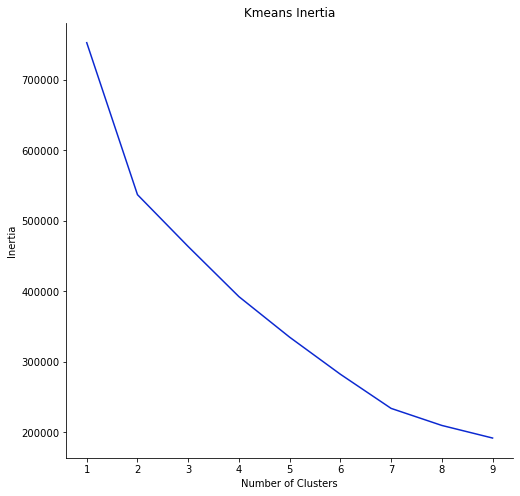

In [344]:
def k_means_intertia(data, num_clusters):
    olist_blue  = '#0C29D1'
    
    clusters = []
    inertia = []
    
    X = data.drop(['customer_unique_id', 'product_id'], axis=1)
#     X = dummy_data(X)
    X = StandardScaler().fit_transform(X)
#     pca = PCA(n_components=3)
#     pca.fit_transform(X)
#     print(pca.explained_variance_ratio_)
    
    for n in range(1,num_clusters):
        
        km = KMeans(n_clusters=n, max_iter=500)
        km.fit(X)
        clusters.append(n)
        inertia.append(km.inertia_)
    
    plt.figure(figsize=(8,8))
    ax = sns.lineplot(clusters, inertia, color=olist_blue)
    ax.set(xlabel='Number of Clusters', ylabel='Inertia', title='Kmeans Inertia')
    sns.despine();
    
    return

k_means_intertia(selected_olist_df, 10)

In [179]:
def kmean_4_cluster(data):
    df = data.drop(['customer_unique_id', 'product_id'], axis=1)
    df = dummy_data(df)

    km = KMeans(n_clusters=3)
    clusters = km.fit_predict(df)
    data["label"] = clusters
    
    return data

customer_info_df = kmean_4_cluster(engineered_olist_df)

/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [182]:
customer_info_df.head()

,customer_unique_id,customer_state,common_payment_type,avg_payment_price,avg_installments,number_of_orders,total_products_ordered,avg_prod_per_order,avg_review_score,most_common_category,avg_prod_weight,product_id,label
0,107e6259485efac66428a56f10801f4f,SP,credit_card,68.87,3.0,1,1,1.0,5.0,health_beauty,950.0,d63c1011f49d98b976c352955b1c4bea,0
1,6062db572f3ef38b7a8ff4307abbfad3,SP,credit_card,650.34,6.0,1,1,1.0,4.0,consoles_games,200.0,3f27ac8e699df3d300ec4a5d8c5cf0b2,0
2,3588484a539617d91500764822230fb6,SP,credit_card,33.84,3.0,1,1,1.0,3.0,telephony,300.0,57d79905de06d8897872c551bfd09358,0
3,1a6cbc34ea404cb0af7ed74df0999354,RJ,credit_card,164.39,1.0,1,1,1.0,4.0,office_furniture,9375.0,1c05e0964302b6cf68ca0d15f326c6ba,1
4,8e5a8d9363eb6296154b65750c8702ca,PR,boleto,30.60,1.0,1,1,1.0,5.0,telephony,350.0,23365beed316535b4105bd800c46670e,0


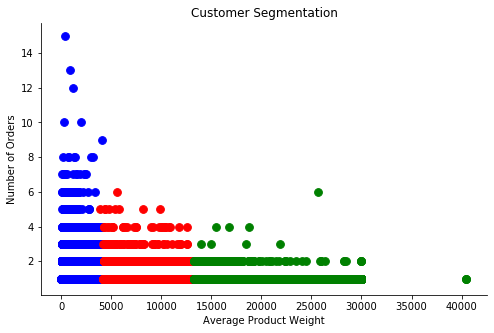

In [194]:
#example of hwo this visually looks (only possible with numerical data)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.scatter(customer_info_df.avg_prod_weight[customer_info_df.label == 0], customer_info_df.number_of_orders[customer_info_df.label == 0], c='blue', s=60)
ax.scatter(customer_info_df.avg_prod_weight[customer_info_df.label == 1], customer_info_df.number_of_orders[customer_info_df.label == 1], c='red', s=60)
ax.scatter(customer_info_df.avg_prod_weight[customer_info_df.label == 2], customer_info_df.number_of_orders[customer_info_df.label == 2], c='green', s=60)
ax.set(xlabel='Average Product Weight', ylabel='Number of Orders', title='Customer Segmentation');
sns.despine();

In [193]:
customer_info_df[customer_info_df.label==2].customer_unique_id.value_counts()

02cbdaaf4623b20082e2a5f80534a1af    1
207f0b00f8451bd80cc5926fefec2d0f    1
8322ac348d132588470c5e8cc56b2bb8    1
223375a331896cbd8946c1edd2dfdde0    1
14fa6bc9a40a5bb2088552c5746c0b37    1
                                   ..
9d73089e629be81dfe8d09d929649d75    1
890428d68645fb2cbb42bc2e46ac2241    1
720c05bfb8fafdbdfb898e4994ffb261    1
bd70535b91eb978735f163b01dd4f7d8    1
4f9abb81a81465dfa9d717f658404d91    1
Name: customer_unique_id, Length: 2478, dtype: int64

Customer breakdown:
    0. Regulars
    1. Occationals
    2. One timers

# Generating Tableau Dashboard

## Recommendation Engine Results

In [131]:
recommendation_results = recommendation_results.merge(customer_info_df[['customer_unique_id', 'label']], how='left', left_on='uid', right_on='customer_unique_id')

#export for tableau visualization
recommendation_results.to_csv('recommendation_results.csv')

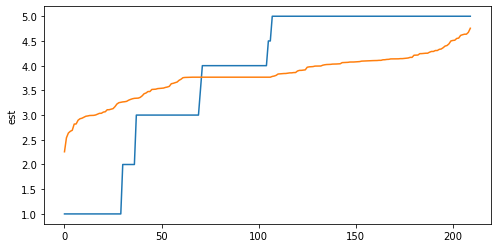

In [130]:
plt.figure(figsize=(8,4))
sns.lineplot(range(recommendation_results[recommendation_results.label==3].shape[0]), recommendation_results[recommendation_results.label==3].rui.sort_values())
sns.lineplot(range(recommendation_results[recommendation_results.label==3].shape[0]), recommendation_results[recommendation_results.label==3].est.sort_values())

In [132]:
recommendation_results.shape

(2842, 10)

In [138]:
customer_info_df[customer_info_df.label==2].number_of_orders

2        4
3        4
7        2
8        2
10       2
        ..
17293    2
17298    2
17304    2
17309    2
17311    2
Name: number_of_orders, Length: 5993, dtype: int64

In [140]:
customer_info_df[customer_info_df.label==2].avg_prod_per_order.value_counts()

1.0    5993
Name: avg_prod_per_order, dtype: int64

# Predicting Customer Drop Off

In [477]:
def pred_feature_engineering(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp).dt.date
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date).dt.date
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date).dt.date
    
    df = data.copy()
    
    df['days_to_delivery'] = df.order_delivered_customer_date - data.order_purchase_timestamp 
    print("Step 1 complete.")
    
    df['estimated_days_to_delivery'] = df.order_estimated_delivery_date - data.order_purchase_timestamp 
    
    df['days_early_late'] = df.estimated_days_to_delivery - df.days_to_delivery #negative = late
    print("Step 2 complete.")
    
    df['number_of_orders'] = df.groupby('customer_unique_id')['order_id'].transform('count')
    print("Step 3 complete.")
    
    df['total_products_ordered'] = df.groupby('customer_unique_id')['customer_unique_id'].transform('count')
    print("Step 4 complete.")
    
    df['avg_review_score'] = df.groupby('customer_unique_id')['review_score'].transform('mean')
    print("Step 5 complete.")
    
    df['avg_prod_weight'] = df.groupby('customer_unique_id')['product_weight_g'].transform('mean')
    print("Step 6 complete.")
    
    df['total_payment_value'] = df.groupby('customer_unique_id')['total_payment'].transform('sum')
    print("Step 7 complete.")
    
    df['number_of_orders'] = df.groupby('customer_unique_id')['order_id'].transform('count')
    print("Step 8 complete.")
    
#     df['most_common_cat'] = df.groupby('customer_unique_id')['product_category_name_english'].transform(lambda x: x.mode().iat[0])    
#     print("Step 9 complete.")
    
#     df['common_pay_type'] = df.groupby('customer_unique_id')['payment_type'].transform(lambda x: x.mode().iat[0])    
#     print("Step 10 complete.")
    
#     df['avg_prod_price'] = df.groupby('customer_unique_id')['price'].transform('mean')
#     print("Step 11 complete.")
    
    return df

In [478]:
feat_eng_df = pred_feature_engineering(full_df)

Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.


In [479]:
feat_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 29 columns):
index                            103612 non-null int64
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null object
order_delivered_customer_date    101386 non-null object
order_estimated_delivery_date    103612 non-null object
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null flo

In [480]:
feat_eng_df

,index,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,product_id,seller_id,price,order_purchase_timestamp,...,total_payment,repeater,days_to_delivery,estimated_days_to_delivery,days_early_late,number_of_orders,total_products_ordered,avg_review_score,avg_prod_weight,total_payment_value
0,0,dd12487859031219d411baa6f6ac20f5,3908,sao paulo,SP,0097f0545a302aafa32782f1734ff71c,b6397895a17ce86decd60b898b459796,7901646fdd36a55f564ffaf2dbccaaf7,158.00,2018-03-05,...,1015.68,1,16 days,16 days,0 days,2,2,1.0,2650.00,2031.36
1,1,dd12487859031219d411baa6f6ac20f5,3908,sao paulo,SP,0097f0545a302aafa32782f1734ff71c,636598095d69a5718e67d2c9a3c7dde6,7901646fdd36a55f564ffaf2dbccaaf7,308.00,2018-03-05,...,1015.68,1,16 days,16 days,0 days,2,2,1.0,2650.00,2031.36
2,2,8004f80e361a5ee23aadb7418a685fc2,12233,sao jose dos campos,SP,00a250dbdb3153cc6ecf4d3f07ef6a17,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,53.99,2017-12-10,...,61.77,1,4 days,19 days,15 days,4,4,2.0,750.00,2548.92
3,3,70457f5d80967f5f4083e0cde7e89ab6,70763,brasilia,DF,00bcee890eba57a9767c7b5ca12d3a1b,6c90c0f6c2d89eb816b9e205b9d6a36a,3bb548e3cb7f70f28e3f11ee9dce0e59,165.50,2017-07-22,...,3090.00,1,5 days,30 days,25 days,4,4,3.0,668.75,12360.00
4,4,70457f5d80967f5f4083e0cde7e89ab6,70763,brasilia,DF,00bcee890eba57a9767c7b5ca12d3a1b,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,175.91,2017-07-22,...,3090.00,1,5 days,30 days,25 days,4,4,3.0,668.75,12360.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103607,86294,d11fd20c68a7d716b6e2df9bccda5b8e,4880,sao paulo,SP,ffefb169ddf34cecc0622a6d3cc387f8,601a360bd2a916ecef0e88de72a6531a,7a67c85e85bb2ce8582c35f2203ad736,129.99,2017-07-02,...,142.10,0,17 days,12 days,-5 days,1,1,1.0,1600.00,142.10
103608,86295,66cd6da20c67f83a9cf37e01a0105812,50790,recife,PE,fff1e3e76b816bfe8ef16678cc53c643,2e910736c31392d46841f315e9511405,7a67c85e85bb2ce8582c35f2203ad736,65.99,2018-02-27,...,86.85,0,8 days,27 days,19 days,1,1,4.0,1100.00,86.85
103609,86296,c71a196d46a70ec611f3922db5755d1d,9715,sao bernardo do campo,SP,fff6b8ca971f8e3ec822e99d0f2d3d21,9afaad66aca8b0c79e4f084a89c9c92b,42bde9fef835393bb8a8849cb6b7f245,199.00,2017-09-15,...,215.83,0,6 days,19 days,13 days,1,1,5.0,150.00,215.83
103610,86297,028c09f007292c4e3a3b10d296e47987,58075,joao pessoa,PB,fff8287bbae429a99bb7e8c21d151c41,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,180.00,2018-03-17,...,912.56,0,21 days,33 days,12 days,1,1,5.0,175.00,912.56


In [395]:
full_df.customer_unique_id.value_counts().sort_values()

3c697899dd702127f600f0c036eb2a2c     1
ff6bc862428c6016d6fef5995491ec81     1
b98de9b9357dc16158a7d4f584574575     1
5ed603e92ce43d47e8f3a5ec4b1746d4     1
116cd8293368aa691e14ac9c9121e3ca     1
                                    ..
1b6c7548a2a1f9037c1fd3ddfed95f33    10
788a2f679187362222b67dfe89da6c1a    10
41a3b256cc497dc952a815b848345cbc    12
3e43e6105506432c953e165fb2acf44c    13
8d50f5eadf50201ccdcedfb9e2ac8455    15
Name: customer_unique_id, Length: 94087, dtype: int64

In [398]:
full_df[full_df.customer_unique_id =='788a2f679187362222b67dfe89da6c1a']

,index,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,product_id,seller_id,price,order_purchase_timestamp,...,order_estimated_delivery_date,payment_type,payment_installments,review_score,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_state,total_payment,repeater
2905,2905,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,20d458d013a3988f71009298fecd8607,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,credit_card,1,1,300.0,bed_bath_table,14940,SP,267.75,1
2906,2906,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,20d458d013a3988f71009298fecd8607,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,voucher,1,1,300.0,bed_bath_table,14940,SP,267.75,1
2907,2907,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,cf6514025ef5d3a93d69d2a7bfa4036b,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,credit_card,1,1,250.0,bed_bath_table,14940,SP,267.75,1
2908,2908,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,cf6514025ef5d3a93d69d2a7bfa4036b,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,voucher,1,1,250.0,bed_bath_table,14940,SP,267.75,1
2909,2909,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,cce679660c66e6fbd5c8091dfd29e9cd,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,credit_card,1,1,250.0,bed_bath_table,14940,SP,267.75,1
2910,2910,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,52eb8ce94864a3bb1be410a545f9ed4c,cce679660c66e6fbd5c8091dfd29e9cd,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:20,...,2017-12-18,voucher,1,1,250.0,bed_bath_table,14940,SP,267.75,1
16431,16431,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,9a19e859f5bd7a0bb22d64d35fa8b979,3472b106bf41b1e7223330cdfb8a3673,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:52,...,2017-12-14,voucher,1,1,250.0,bed_bath_table,14940,SP,59.50,1
16432,16432,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,9a19e859f5bd7a0bb22d64d35fa8b979,3472b106bf41b1e7223330cdfb8a3673,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:52,...,2017-12-14,voucher,1,4,250.0,bed_bath_table,14940,SP,59.50,1
16433,16433,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,9a19e859f5bd7a0bb22d64d35fa8b979,3472b106bf41b1e7223330cdfb8a3673,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:52,...,2017-12-14,credit_card,1,1,250.0,bed_bath_table,14940,SP,59.50,1
16434,16434,788a2f679187362222b67dfe89da6c1a,4909,sao paulo,SP,9a19e859f5bd7a0bb22d64d35fa8b979,3472b106bf41b1e7223330cdfb8a3673,d2374cbcbb3ca4ab1086534108cc3ab7,17.9,2017-11-24 23:37:52,...,2017-12-14,credit_card,1,4,250.0,bed_bath_table,14940,SP,59.50,1


In [407]:
full_df.order_purchase_timestamp = pd.to_datetime(full_df.order_purchase_timestamp)

In [408]:
first_purchase = full_df.loc[full_df.groupby('customer_unique_id')['order_purchase_timestamp'].idxmin()]

In [413]:
first_purchase[first_purchase.repeater == 1]

,index,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,product_id,seller_id,price,order_purchase_timestamp,...,order_estimated_delivery_date,payment_type,payment_installments,review_score,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_state,total_payment,repeater
9345,9345,00053a61a98854899e70ed204dd4bafe,80410,curitiba,PR,44e608f2db00c74a1fe329de44416a4e,62984ea1bba7fcea1f5b57084d3bf885,218d46b86c1881d022bce9c68a7d4b15,191.00,2018-02-28 11:15:41,...,2018-03-26,credit_card,3,1,1092.0,sports_leisure,14070,SP,838.36,1
2253,2253,000bfa1d2f1a41876493be685390d6d3,11095,santos,SP,fd61441ba2a7b57e6342862e779b10b0,bb15f9ba2ec6e36ab6c9e88d17430d64,b372ee768ed69e46ca8cdbd267aa7a38,35.00,2017-09-29 14:46:58,...,2017-10-26,credit_card,4,5,150.0,fashion_bags_accessories,15013,SP,93.70,1
12539,12539,000de6019bb59f34c099a907c151d855,11612,sao sebastiao,SP,c6d61340bd8baeedca7cc8e7f7ec07e9,af0a917aec9cea3b353ece61a8825326,da8622b14eb17ae2831f4ac5b9dab84a,89.90,2017-08-17 19:10:33,...,2017-09-06,credit_card,4,2,1200.0,bed_bath_table,13405,SP,514.88,1
10377,10377,000e309254ab1fc5ba99dd469d36bdb4,72872,valparaiso de goias,GO,c5d3fae065a8090bae39f4f34b14cd06,b73091f98b819cf7a339f74ece86aa4b,a6fe7de3d16f6149ffe280349a8535a0,59.90,2018-06-25 09:53:57,...,2018-07-24,voucher,1,3,200.0,fashion_underwear_beach,14401,SP,78.42,1
14087,14087,000fbf0473c10fc1ab6f8d2d286ce20c,13330,indaiatuba,SP,87440e08790d85796f5b8bc9f5ed2707,38021cef829efa264df6f9d21c4df6e9,ce248b21cb2adc36282ede306b7660e5,119.87,2018-07-26 09:43:52,...,2018-08-17,boleto,1,5,250.0,musical_instruments,89251,SC,1449.52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12840,12840,ffd6f65402f2bc47238ecd2bdc93e0d4,30550,belo horizonte,MG,ea134380898c6f487ff7113ecdd6319a,454ae5002aaf2821ecb6ad6035b78498,218d46b86c1881d022bce9c68a7d4b15,21.00,2018-05-09 20:59:26,...,2018-06-04,credit_card,1,5,300.0,sports_leisure,14070,SP,166.92,1
9247,9247,ffe254cc039740e17dd15a5305035928,37640,extrema,MG,39a0e2f723def2e12a51e963006c9242,18fc07433ae4bcd5a8bdf658b2c6e40d,dc4a0fc896dc34b0d5bfec8438291c80,37.18,2017-04-02 16:33:30,...,2017-04-28,credit_card,2,1,900.0,bed_bath_table,14940,SP,51.70,1
16688,16688,ffeddf8aa7cdecf403e77b2e9a99e2ea,68030,santarem,PA,b40d597f0eb58c117cb5d9e424f10426,94974b8c613bc6fae9700e6c01f626ae,de23c3b98a88888289c6f5cc1209054a,165.00,2018-05-13 16:04:51,...,2018-06-13,voucher,1,2,225.0,stationery,5530,SP,204.20,1
4784,4784,fff7219c86179ca6441b8f37823ba3d3,28680,cachoeiras de macacu,RJ,2c43da70769acf988d27b050b189c7fe,592962829d5a715304344e656e39108a,8160255418d5aaa7dbdc9f4c64ebda44,122.90,2017-12-27 18:57:38,...,2018-01-31,debit_card,1,4,1750.0,bed_bath_table,14940,SP,531.60,1


In [412]:
first_purchase.repeater.value_counts(normalize=True)

0    0.917226
1    0.082774
Name: repeater, dtype: float64

In [414]:
first_purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94087 entries, 91635 to 70913
Data columns (total 21 columns):
index                            94087 non-null int64
customer_unique_id               94087 non-null object
customer_zip_code_prefix         94087 non-null int64
customer_city                    94087 non-null object
customer_state                   94087 non-null object
order_id                         94087 non-null object
product_id                       94087 non-null object
seller_id                        94087 non-null object
price                            94087 non-null float64
order_purchase_timestamp         94087 non-null datetime64[ns]
order_delivered_customer_date    92008 non-null datetime64[ns]
order_estimated_delivery_date    94087 non-null datetime64[ns]
payment_type                     94087 non-null object
payment_installments             94087 non-null int64
review_score                     94087 non-null int64
product_weight_g                 94086 no

In [509]:
def first_feature_engineering(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp).dt.date
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date).dt.date
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date).dt.date
    
    df = data.copy()
    
    df['days_to_delivery'] = (df.order_delivered_customer_date - data.order_purchase_timestamp).apply(lambda x: x.days) 
    print("Step 1 complete.")
    
    df['estimated_days_to_delivery'] = (df.order_estimated_delivery_date - data.order_purchase_timestamp).apply(lambda x: x.days)
    
    df['days_early_late'] = (df.estimated_days_to_delivery - df.days_to_delivery)#negative = late
    print("Step 2 complete.")    
    
    df['seller_avg_rating'] = df.groupby('seller_id')['review_score'].transform('mean')
    print("Step 3 complete.")
    
    return df

In [510]:
feat_first_purchase = first_feature_engineering(first_purchase)

Step 1 complete.
Step 2 complete.
Step 3 complete.


In [517]:
feat_first_purchase['days_early_late'].value_counts()

 14.0     6765
 13.0     5673
 15.0     5100
 8.0      4621
 7.0      4616
          ... 
-123.0       1
-85.0        1
-72.0        1
-97.0        1
 135.0       1
Name: days_early_late, Length: 195, dtype: int64

In [512]:
def first_feature_select(data):
    features = ['customer_zip_code_prefix', 'payment_type', 'days_to_delivery',
                'days_early_late', 'payment_installments','review_score','product_weight_g',
                'product_category_name_english','seller_avg_rating', 'repeater']
    
    df = data.copy()
    df = df[features]
    df = df.dropna(axis=0)
    
#     df.days_to_delivery = df.days_to_delivery.astype('int64')
#     df.days_early_late = df.days_early_late.astype('int64')
    
    return df

In [513]:
selected_first_purchase = first_feature_select(feat_first_purchase)

Next step is to predict if a user will return or not. Then calculat additional $$ the company could make if they got 5% of those customers who weren't going to repeat to repeat. 

In [455]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, roc_auc_score, 
                             roc_curve, confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV


In [535]:
def roc_curve_plotting(fpr, tpr, auc_roc):
    """Takes in fpr, tpr, and auc_roc to produce an ROC curve for all
    validation sets."""

    plt.figure(figsize=(5,5))
    lw = 2
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i],
                 lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
    plt.show()
    return

def dummy_data(data):
    cat_cols = [col for col in data.columns if (data[col].dtype == 'O')]
    dummied_data = pd.get_dummies(data, columns=cat_cols, drop_first = True)
    return dummied_data

X = selected_first_purchase.drop('repeater', axis=1)
X = dummy_data(X)
y = selected_first_purchase['repeater']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=19)

# fit xgboost on an imbalanced classification dataset

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=19)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
# summarize performance
print('Mean accuracy: %.5f' % np.mean(scores))

# lr = LogisticRegression(C=10, solver='lbfgs')
# lr.fit(X_train, y_train)

# model = RandomForestClassifier(n_estimators=200,  min_samples_leaf=10)
# model.fit(X_train, y_train)
# prediction = model.predict(X_test)
# prediction_prob = model.predict_proba(X_test)

# print("Confusion Matrix")
# print(confusion_matrix(y_test, prediction))
# print("Recall Score")
# print(recall_score(y_test, prediction))
# print("Precision Score")
# print(precision_score(y_test, prediction))
# print("Accuracy Score")
# print(accuracy_score(y_test, prediction))

# fpr, tpr, thresholds = roc_curve(y_test, prediction_prob[:,1], pos_label=1)
# roc_auc = roc_auc_score(y_test, prediction_prob[:,1])
# #roc_curve_plotting(fpr, tpr, roc_auc)



Mean accuracy: 0.91792


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 90, 130],
    'max_features': [2, 3],
    'min_samples_leaf': [5,10],
    'min_samples_split': [8, 20, 50],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)


grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

In [468]:
selected_first_purchase.days_early_late.value_counts()

1070116000000000    5
620467000000000     4
796048000000000     4
1147930000000000    4
1137792000000000    4
                   ..
1318087000000000    1
1732513000000000    1
1563996000000000    1
798438000000000     1
787255000000000     1
Name: days_early_late, Length: 87846, dtype: int64

In [495]:
selected_first_purchase.head()

,customer_zip_code_prefix,payment_type,days_to_delivery,days_early_late,payment_installments,review_score,product_weight_g,product_category_name_english,seller_avg_rating,repeater
91635,7787,credit_card,518400000000000,432000000000000,8,5,1500.0,bed_bath_table,4.175566,0
51932,6053,credit_card,259200000000000,432000000000000,1,4,375.0,health_beauty,4.255814,0
35533,88115,credit_card,2246400000000000,172800000000000,8,3,1500.0,stationery,4.140133,0
20035,66812,credit_card,1728000000000000,1036800000000000,4,4,150.0,telephony,3.920635,0
80534,18040,credit_card,1123200000000000,691200000000000,6,5,6050.0,telephony,3.785479,0


In [515]:
selected_first_purchase

,customer_zip_code_prefix,payment_type,days_to_delivery,days_early_late,payment_installments,review_score,product_weight_g,product_category_name_english,seller_avg_rating,repeater
91635,7787,credit_card,6.0,5.0,8,5,1500.0,bed_bath_table,4.175566,0
51932,6053,credit_card,3.0,5.0,1,4,375.0,health_beauty,4.255814,0
35533,88115,credit_card,26.0,2.0,8,3,1500.0,stationery,4.140133,0
20035,66812,credit_card,20.0,12.0,4,4,150.0,telephony,3.920635,0
80534,18040,credit_card,13.0,8.0,6,5,6050.0,telephony,3.785479,0
...,...,...,...,...,...,...,...,...,...,...
13948,55250,credit_card,28.0,27.0,10,5,30000.0,health_beauty,4.345455,1
58085,44054,credit_card,30.0,3.0,1,4,1720.0,baby,4.106280,0
103514,78552,credit_card,15.0,30.0,1,5,600.0,auto,3.857143,0
55912,29460,credit_card,12.0,14.0,5,5,444.0,watches_gifts,4.019820,0


# Creating Dashboard

In [ ]:
full_df.info()

In [529]:
def full_def_feature_engineering(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp).dt.date
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date).dt.date
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date).dt.date
    
    df = data.copy()
    
    df['days_to_delivery'] = (df.order_delivered_customer_date - data.order_purchase_timestamp).apply(lambda x: x.days) 
    print("Step 1 complete.")
    
    df['estimated_days_to_delivery'] = (df.order_estimated_delivery_date - data.order_purchase_timestamp).apply(lambda x: x.days)
    
    df['days_early_late'] = (df.estimated_days_to_delivery - df.days_to_delivery)#negative = late
    print("Step 2 complete.")    
    
    df['seller_avg_rating'] = df.groupby('seller_id')['review_score'].transform('mean')
    print("Step 3 complete.")
    
    df = df.dropna(axis=0)
    
    return df

In [530]:
feat_eng_full = full_def_feature_engineering(full_df)

Step 1 complete.
Step 2 complete.
Step 3 complete.


In [531]:
feat_eng_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101385 entries, 0 to 103611
Data columns (total 25 columns):
index                            101385 non-null int64
customer_unique_id               101385 non-null object
customer_zip_code_prefix         101385 non-null int64
customer_city                    101385 non-null object
customer_state                   101385 non-null object
order_id                         101385 non-null object
product_id                       101385 non-null object
seller_id                        101385 non-null object
price                            101385 non-null float64
order_purchase_timestamp         101385 non-null object
order_delivered_customer_date    101385 non-null object
order_estimated_delivery_date    101385 non-null object
payment_type                     101385 non-null object
payment_installments             101385 non-null int64
review_score                     101385 non-null int64
product_weight_g                 101385 non-null flo

In [532]:
#export for tableau visual
feat_eng_full.to_csv('data/feat_engine_full_df.csv')

# Time Series Sales Forecasting

In [1079]:
time_data = olist_data[['order_purchase_timestamp','total_payment']]
time_data.order_purchase_timestamp = pd.to_datetime()

In [ ]:
time_data.to_csv('data/time_data.csv', index=False)

In [1473]:
def load_time_data():
    time_data = pd.read_csv('data/time_data.csv',infer_datetime_format=True, header=0,
                             index_col=0, names=['day', 'sales'], engine='python')

    time_data.index = pd.to_datetime(time_data.index)
    time_data = time_data.resample('d').sum()
    time_data = time_data[time_data.index > '2017-02-01']
    time_data = time_data[time_data.index < '2018-08-27']
    return time_data

daily_sales = load_time_data()

In [1451]:
daily_sales.describe()

,sales
count,571.000000
mean,41328.625657
std,25719.939178
min,5939.290000
25%,24236.355000
50%,36943.660000
75%,53111.780000
max,311345.680000


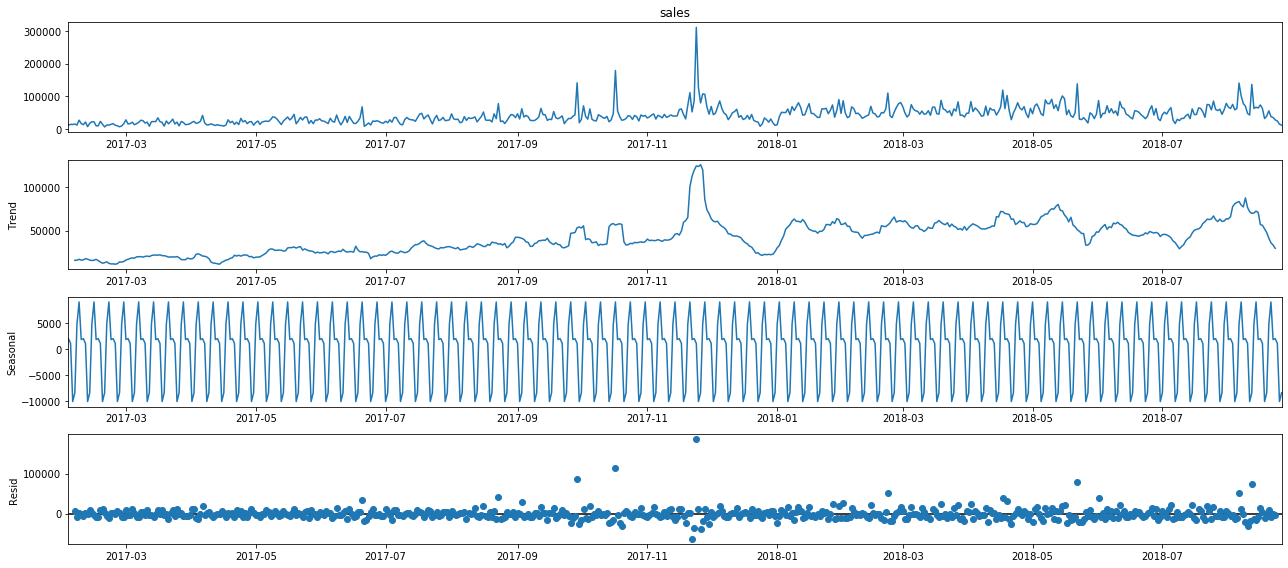

In [1574]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(daily_sales.sales, model='additive')
fig = decomposition.plot()
plt.show()

In [1452]:
weekly_sales = daily_sales.resample('W').mean()

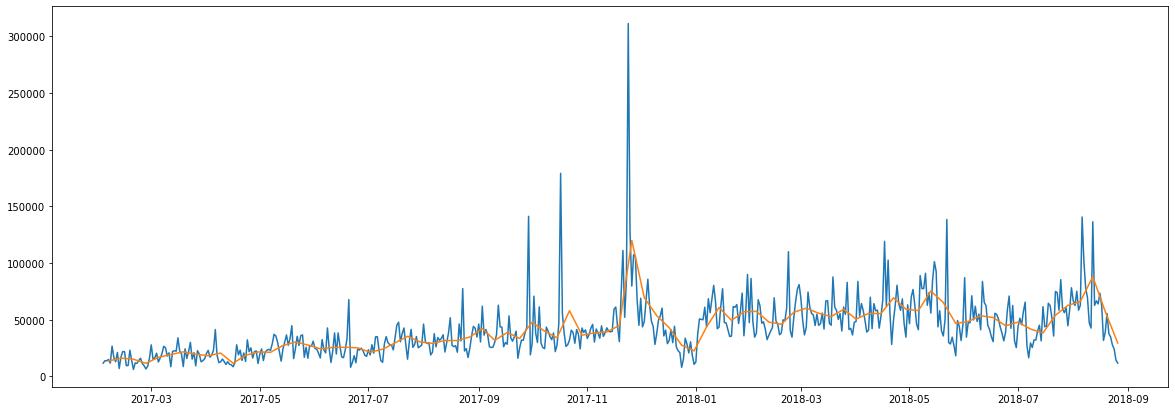

In [1453]:
plt.figure(figsize=(20,7))
plt.plot(daily_sales)
plt.plot(weekly_sales);

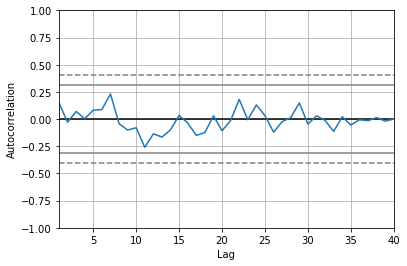

In [1454]:
autocorrelation_plot(daily_sales[:40])
plt.show();

In [1455]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    return

Test Statistic           -3.889607
p-value                   0.002113
Lags Used                 8.000000
Observations Used       562.000000
Critical Value (1%)      -3.442039
Critical Value (5%)      -2.866697
Critical Value (10%)     -2.569516
dtype: float64


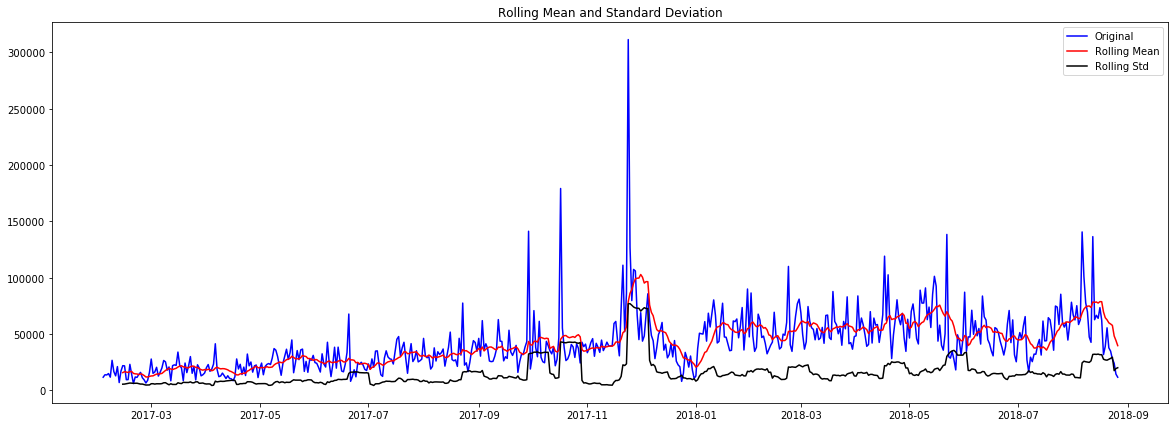

In [1456]:
dftest(daily_sales.sales)

In [1457]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

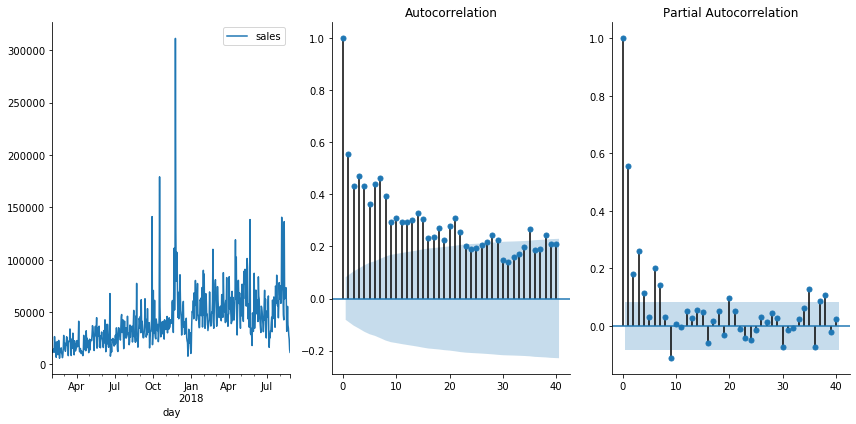

In [1458]:
plots(daily_sales, lags=40);

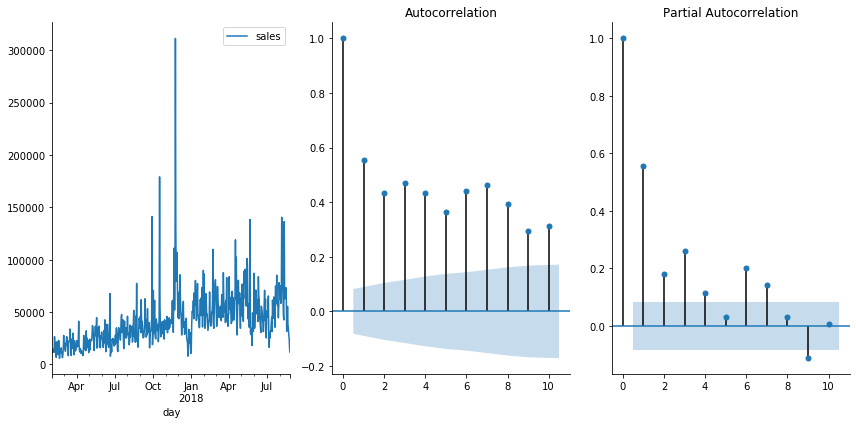

In [1459]:
plots(daily_sales, lags=10);

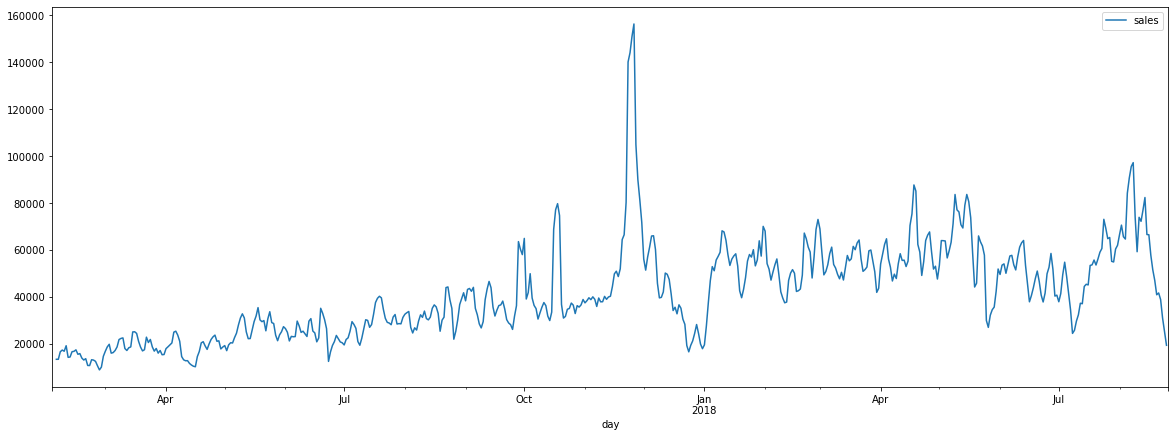

In [1460]:
daily_sales.rolling(window=4, center=True).mean().plot(figsize=(20,7));

In [1461]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from sklearn.metrics import mean_squared_error


In [1462]:
model = sm.tsa.statespace.SARIMAX(daily_sales.sales, order=(1,0,0),
                                 trend='n')
results = model.fit()

In [1463]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  571
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6555.994
Date:                Fri, 20 Mar 2020   AIC                          13115.989
Time:                        09:15:47   BIC                          13124.683
Sample:                    02-02-2017   HQIC                         13119.381
                         - 08-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8751      0.009     98.964      0.000       0.858       0.892
sigma2      5.494e+08   8.48e-14   6.48e+21      0.000    5.49e+08    5.49e+08
===================================================================================
Ljung-Box (Q):                      196.79   Jarque-Bera (JB):             16125.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.52   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.62e+39. Standard errors may be unstable.
"""

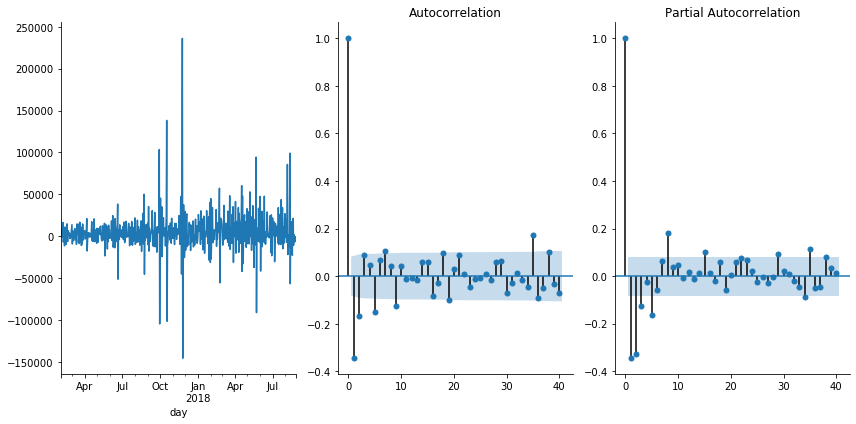

In [1464]:
plots(results.resid, lags=40);

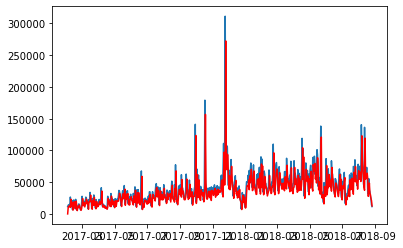

In [1465]:
plt.plot(daily_sales.sales)
plt.plot(results.fittedvalues, color='red')

In [1466]:
daily_sales

,sales
day,
2017-02-02,11560.95
2017-02-03,13740.54
2017-02-04,13583.79
2017-02-05,14792.03
2017-02-06,11596.32
...,...
2018-08-22,34669.40
2018-08-23,27692.14
2018-08-24,23965.99


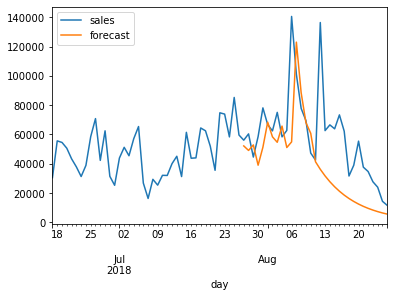

In [1469]:
# plot predictions
daily_sales['forecast'] = results.predict(start = 540, end= 571, 
                                          dynamic=15)  
daily_sales[500:][['sales', 'forecast']].plot();

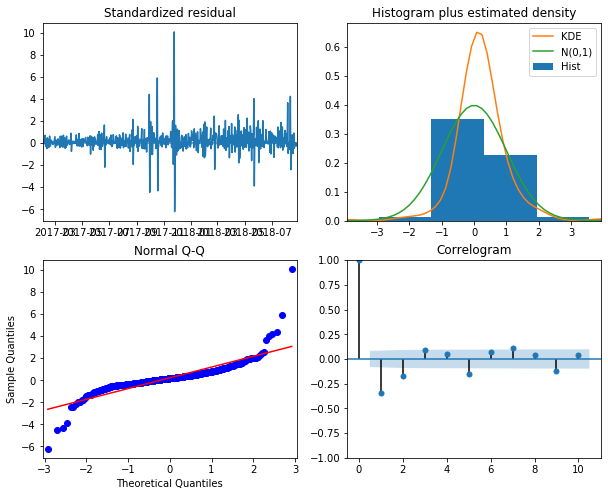

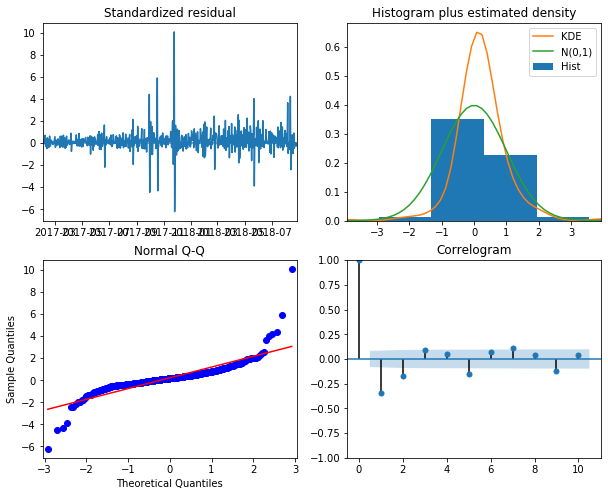

In [1470]:
results.plot_diagnostics(figsize=(10, 8))

In [1475]:
ds_2 = daily_sales.copy()

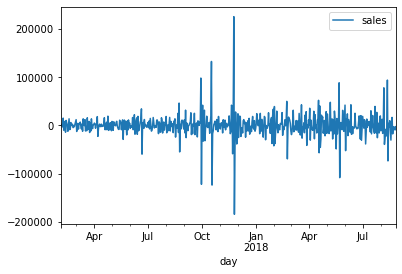

In [1476]:
ds_2 = ds_2.diff().dropna()
ds_2.plot()

Test Statistic         -1.120887e+01
p-value                 2.150387e-20
Lags Used               7.000000e+00
Observations Used       5.620000e+02
Critical Value (1%)    -3.442039e+00
Critical Value (5%)    -2.866697e+00
Critical Value (10%)   -2.569516e+00
dtype: float64


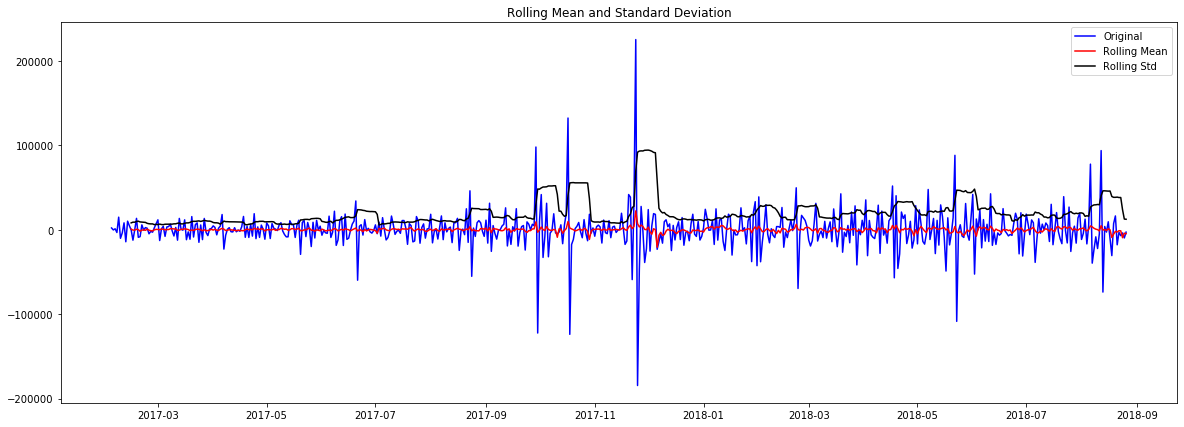

In [1477]:
dftest(ds_2)

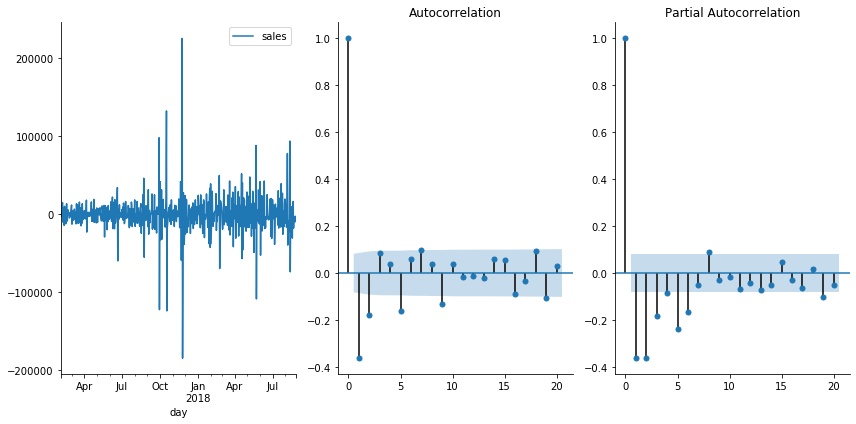

In [1478]:
plots(ds_2, lags=20);

In [1546]:
model2 = sm.tsa.statespace.SARIMAX(daily_sales.sales, order=(0,1,6))
results2 = model2.fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  571
Model:               SARIMAX(0, 1, 6)   Log Likelihood               -6450.235
Date:                Fri, 20 Mar 2020   AIC                          12914.470
Time:                        09:44:45   BIC                          12944.890
Sample:                    02-02-2017   HQIC                         12926.339
                         - 08-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6340      0.034    -18.889      0.000      -0.700      -0.568
ma.L2         -0.1804      0.053     -3.422      0.001      -0.284      -0.077
ma.L3          0.0835      0.043      1.943      0.052      -0.001       0.168
ma.L4         -0.0622      0.069     -0.898      0.369      -0.198       0.073
ma.L5         -0.1252      0.065     -1.926      0.054      -0.253       0.002
ma.L6          0.1137      0.043      2.633      0.008       0.029       0.198
sigma2      4.127e+08   2.89e-10   1.43e+18      0.000    4.13e+08    4.13e+08
===================================================================================
Ljung-Box (Q):                       81.87   Jarque-Bera (JB):             41191.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             4.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.51e+32. Standard errors may be unstable.
"""

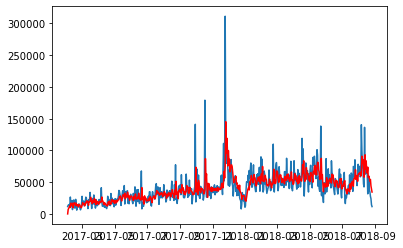

In [1547]:
plt.plot(daily_sales.sales)
plt.plot(results2.fittedvalues, color='red')

In [1548]:
daily_sales_dif_test = daily_sales.copy()

In [1549]:
daily_sales_dif_test

,sales
day,
2017-02-02,11560.95
2017-02-03,13740.54
2017-02-04,13583.79
2017-02-05,14792.03
2017-02-06,11596.32
...,...
2018-08-22,34669.40
2018-08-23,27692.14
2018-08-24,23965.99


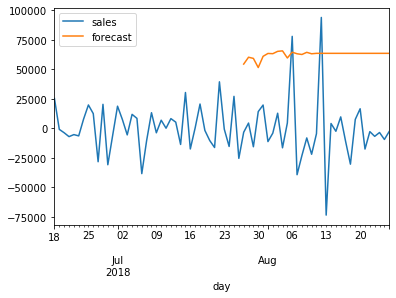

In [1550]:
# plot predictions
ds_2['forecast'] = results2.predict(start = 540, end= 570, dynamic=10)
ds_2[500:][['sales', 'forecast']].plot();

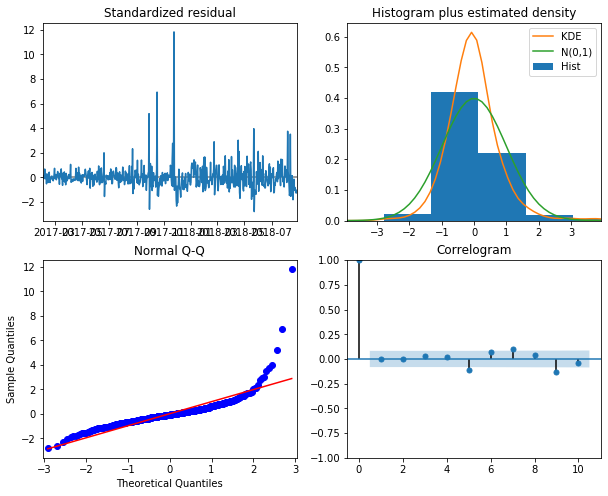

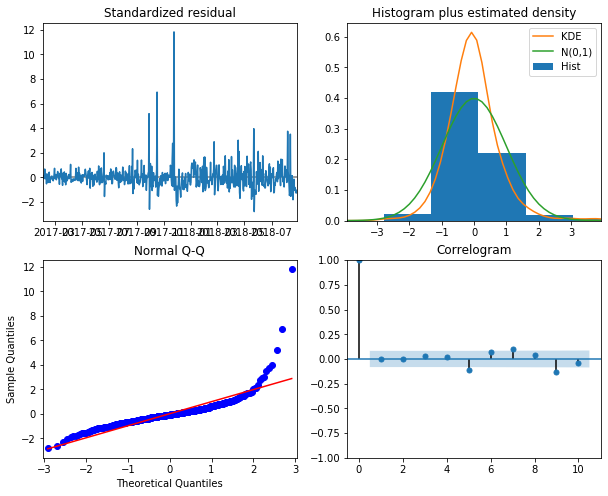

In [1509]:
results2.plot_diagnostics(figsize=(10, 8))

# Smoothing

In [1551]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [1556]:
daily_sales

,sales
day,
2017-02-02,11560.95
2017-02-03,13740.54
2017-02-04,13583.79
2017-02-05,14792.03
2017-02-06,11596.32
...,...
2018-08-22,34669.40
2018-08-23,27692.14
2018-08-24,23965.99


In [1559]:
train, test = daily_sales[:500], daily_sales[500:]

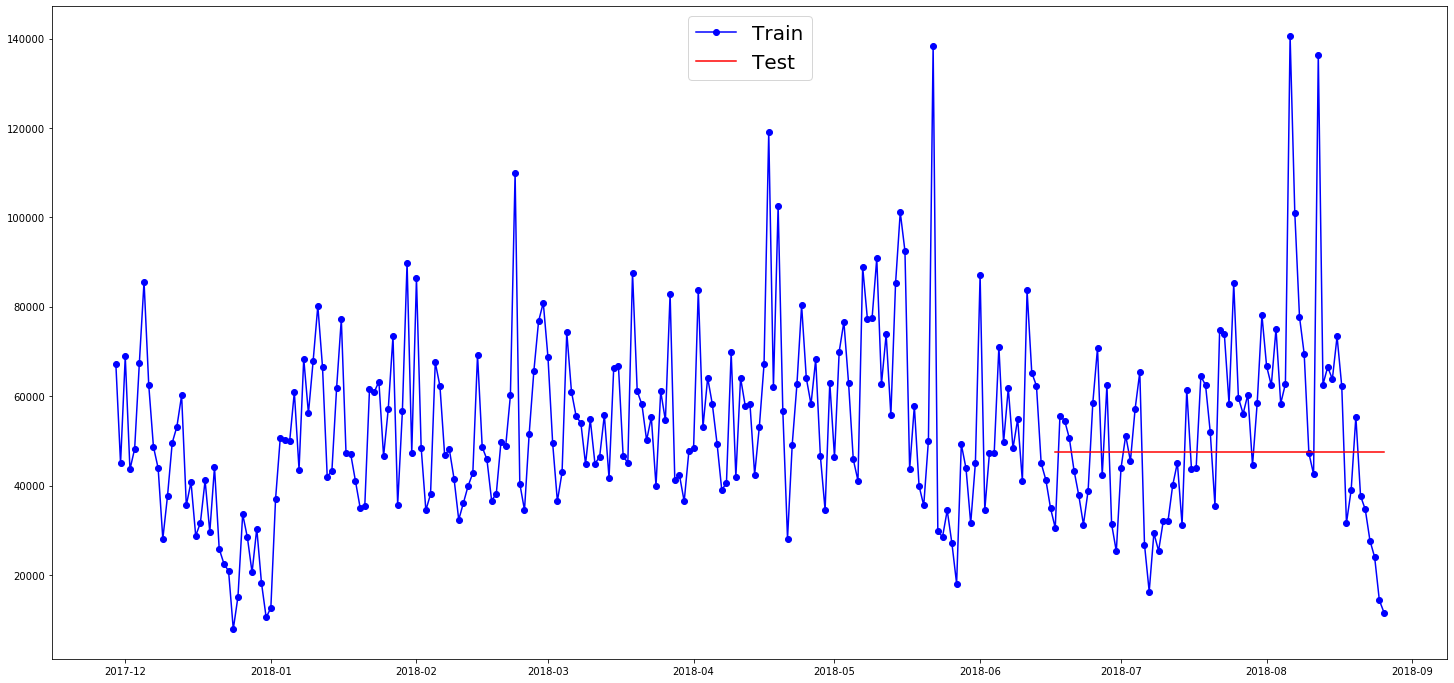

In [1570]:
fit1 = ExponentialSmoothing(seasonal_periods=7, seasonal='add',
                            train).fit(use_boxcox=True)
pred1 = fit1.predict(start=test.index[0], end=test.index[-1])
plt.figure(figsize=(25,12))
plt.plot(daily_sales.index[300:], daily_sales[300:], label=
         'Train', color="blue", marker="o")
plt.plot(test.index, pred1, label='Test', color='red')
plt.legend(loc=9, prop={'size': 20})
plt.show();

# Repeater Info For Pres

In [1582]:
repeater_data.groupby('customer_unique_id')['order_id'].count()

customer_unique_id
00053a61a98854899e70ed204dd4bafe    2
000bfa1d2f1a41876493be685390d6d3    2
000de6019bb59f34c099a907c151d855    2
000e309254ab1fc5ba99dd469d36bdb4    2
000fbf0473c10fc1ab6f8d2d286ce20c    2
                                   ..
ffd6f65402f2bc47238ecd2bdc93e0d4    2
ffe254cc039740e17dd15a5305035928    2
ffeddf8aa7cdecf403e77b2e9a99e2ea    2
fff7219c86179ca6441b8f37823ba3d3    2
fffcf5a5ff07b0908bd4e2dbc735a684    2
Name: order_id, Length: 7788, dtype: int64

In [1584]:
repeater_data.groupby(['customer_unique_id', 'order_id'])['product_id'].count().mean()

1.5802300109529026

In [1586]:
first_timer_data.groupby(['customer_unique_id', 'order_id'])['product_id'].count().mean()

1.0

In [1596]:
q = daily_sales.sales.quantile(q=0.99)
daily_sales[daily_sales.sales < q].mean()

sales    39914.552761
dtype: float64

In [1613]:
first_timer_data.groupby(['customer_unique_id'])['order_id'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcc512b7dfecaffd80f13614af1d16    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 86299, dtype: int64

In [1616]:
repeater_data.customer_unique_id.value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c    13
41a3b256cc497dc952a815b848345cbc    12
1b6c7548a2a1f9037c1fd3ddfed95f33    10
788a2f679187362222b67dfe89da6c1a    10
                                    ..
8cce325d75f2cc11240b0dcf1d8e69ff     2
057583d44728a47f6f223414b7e6cc83     2
bb8de63c9f7b07330e2be9741068561c     2
719268f22cb2d1632471b52cfddcb420     2
af8937e6d92487a6c9393abcf5120e32     2
Name: customer_unique_id, Length: 7788, dtype: int64

In [1618]:
first_timer_data.customer_unique_id.value_counts().sort_values()

43e195ceb5ab683d2ececb21906a0bc7    1
ad450c51ea517736f1ccd3dae3f1506a    1
67d8dfc133e477f08e7c296b83209c56    1
5e6a352922e29670caf312ca809093e1    1
23edc5a3d1e401df09610fff81a7551a    1
                                   ..
d034b95cce3e920a2b8157c196e92505    1
51bc7e97d44cf34b962b5301810d45dd    1
7bc209195f4356a7a1bea27a2a80265e    1
414c84ad495003b943019c464580f531    1
eef70e28876f73d3076a39e54b764c8a    1
Name: customer_unique_id, Length: 86299, dtype: int64

In [1622]:
x = olist_data.groupby('customer_unique_id')['order_id'].count().sort_values().reset_index()

In [1624]:
first = x[x.order_id ==1].shape

(86299, 2)

In [1625]:
x[x.order_id >1].shape

(7788, 2)

In [1626]:
x[x.order_id >1].shape[0] / (x[x.order_id >1].shape[0] + x[x.order_id ==1].shape[0])

0.0827744534313986

In [1627]:
first_timer_data.shape

(86299, 21)

In [1629]:
x[x.order_id >1].mean()

order_id    2.223035
dtype: float64

In [1632]:
86299 * .1 * 120.75136917679554

1042072.2408588277

In [1637]:
≈.order_purchase_timestamp = pd.to_datetime(first_timer_data.order_purchase_timestamp).dt.date

In [1647]:
y = first_timer_data.groupby('order_purchase_timestamp')['total_payment'].sum().reset_index()
y

,order_purchase_timestamp,total_payment
0,2016-09-05,75.06
1,2016-10-02,109.34
2,2016-10-03,549.68
3,2016-10-04,10915.75
4,2016-10-05,14344.92
...,...,...
607,2018-08-25,10742.77
608,2018-08-26,8736.06
609,2018-08-27,5328.43
610,2018-08-28,4389.15


In [1645]:
# customers * 10% * avg price/prod / number of days in dataset
86299 * .1 * 120.75136917679554 / 612 * 365

621497.3331919479

In [1648]:
y.total_payment.sum()

16500947.690000001

In [1649]:
621497/16500947

0.03766432314460497

# testing other stuff

In [1713]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
        
    return user_prod_reviewscore_data

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df



def final_model(data):
    user_product_df = create_user_ratings_df(data)
    user_ratings_matrix = surprise_df(user_product_df)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.2, random_state=19)
    
    params = {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} 
    sim_options = {'name': 'cosine'}
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'], sim_options=sim_options)
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(repeater_data)

# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

TypeError: __init__() got an unexpected keyword argument 'sim_options'

In [1715]:
repeater_data.product_id.nunique()

9006